In [6]:
#input is a strategy, like a repair sequence
#loop
#spend time, repair a node, assume repair is instant
#accumulate and compute resilience triangle
#re-check the functioning bus nodes if the repaired node is a bus node
#change the network parameters and re-run the model
#until sequence end

#repair sequence is some sequence of all broken links and bus
#use heuristic to find out the optimum solution


#this is a test comment
from power_util import delete_buses
from power_util import get_functional_nodes
from road_util import capacity_adjustment
from road_util import eval_tot_OD_travel_time
from interdependency import power_to_road
from run_tapb import run_tapb
from interdependency import repair_path_time
from plot_resilience import plot_triangles_seperate,plot_triangle_tot
import random
from deap import base, creator, tools, algorithms
import itertools
import os
from datetime import datetime
import shutil
import time

power_road_factor=0.5
broken_link_factor=0


def load_disrupted_scenatio(broken_buses,broken_links):
    unfunctional_nodes = delete_buses(broken_buses)
    capacity_adjustment(Org_network,Network1,broken_links,broken_link_factor) #delete link equal to change capacity into 0
    power_to_road(unfunctional_nodes,Network1,Network2,power_road_factor)   #This will edit the capacity of roadway link due to traffic light
    files=[]
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S-%f")[:23]
    os.makedirs(backup_dir, exist_ok=True)
    #backup_filepath=backup_dir+timestamp
    #shutil.copy2(Network2, backup_filepath)
    #files.append(timestamp)
    if os.path.exists('s.txt'):
        os.remove('s.txt')
    run_tapb(Network2,'tap-b/net/SiouxFalls_trips.txt') # 1. fix newest folder issue, #2 this is ugly now, change to parameters input later
    #shutil.copy2('flows.txt', backup_filepath+'flows.txt')
    if os.path.exists(Network2):
        os.remove(Network2)
    return files

def eval_road_resilience(broken_buses,broken_links):
    load_disrupted_scenatio(broken_buses,broken_links)
    #total travel time full Sioux Falls network:7,475,338
    return 7475338/eval_tot_OD_travel_time() 

def eval_power_resilience(broken_buses):
    # This represents "unsatisfied demand" 
    return 1-len(delete_buses(broken_buses))/33

def resilience_triangle(functionality,time):
    #求解若干个梯形面积之和
    #implement financial measures for different weights
    complement=0
    functionality_for_triangle=functionality+[1]
    for i in range(len(functionality)):
        complement+=(1-functionality_for_triangle[i]+1-functionality_for_triangle[i+1])*time[i]/2
    return complement

def resilience_evaluation(repair_seq):
    #This gives resilience "triangle"
    repair_seq=repair_seq.copy()
    resilience_road=[]
    resilience_power=[]
    time=[]
    net_file_names=[]
    previous_node=13
    while len(repair_seq)>0:
        broken_buses=[]
        broken_links=[]
        for item in repair_seq:
            if isinstance(item,int):
                broken_buses.append(item)
            else:
                broken_links.append(item)
        #take road output and read travel time, give number
        resilience_road.append(eval_road_resilience(broken_buses,broken_links))
        #take power output and give number
        resilience_power.append(eval_power_resilience(broken_buses))
        #repair and continue
        current_node,current_move_time=repair_path_time('s.txt',repair_seq[0],previous_node)
        time.append(current_move_time) 
        broken_buses=[bus for bus in broken_buses if bus!=repair_seq[0]]
        broken_links=[link for link in broken_links if link!=repair_seq[0]]
        #set up for next loop
        previous_node=current_node
        repair_seq.pop(0)
        #net_file_names.append(load_disrupted_scenatio(broken_buses,broken_links))
    full_resilience = resilience_triangle(resilience_road,time)+resilience_triangle(resilience_power,time)
    return full_resilience, resilience_road,resilience_power,time,net_file_names

###########################################################################################
#This is for the comparison between optimal considering interdependency and repair by type
##########################################################################################
def cxOrderedGrouped(ind1, ind2):
    """执行有序交叉 (Order Crossover, OX)，确保不产生重复元素且保持元组和整数的分组顺序。"""
    # Split individuals into tuple and int groups
    tuples_ind1 = [x for x in ind1 if isinstance(x, tuple)]
    ints_ind1 = [x for x in ind1 if isinstance(x, int)]
    tuples_ind2 = [x for x in ind2 if isinstance(x, tuple)]
    ints_ind2 = [x for x in ind2 if isinstance(x, int)]
    
    # Apply order crossover to tuples and ints separately
    def order_crossover(part1, part2):
        size = len(part1)
        a, b = sorted(random.sample(range(size), 2))
        
        child1 = [None] * size
        child2 = [None] * size
        
        # Copy the crossover slice from the first parent to the first child
        child1[a:b + 1] = part1[a:b + 1]
        child2[a:b + 1] = part2[a:b + 1]
        
        # Fill the remaining positions with the other parent's elements
        fill_pos1, fill_pos2 = (b + 1) % size, (b + 1) % size
        for i in range(size):
            pos = (b + 1 + i) % size
            if part2[pos] not in child1:
                child1[fill_pos1] = part2[pos]
                fill_pos1 = (fill_pos1 + 1) % size
            if part1[pos] not in child2:
                child2[fill_pos2] = part1[pos]
                fill_pos2 = (fill_pos2 + 1) % size
        
        return child1, child2
    
    # Perform order crossover for both tuples and integers
    child1_tuples, child2_tuples = order_crossover(tuples_ind1, tuples_ind2)
    child1_ints, child2_ints = order_crossover(ints_ind1, ints_ind2)
    
    # Combine tuples and ints back together
    child1 = child1_tuples + child1_ints
    child2 = child2_tuples + child2_ints
    
    return creator.Individual(child1), creator.Individual(child2)

def mutShuffleIndexesGrouped(individual, indpb):
    """执行突变操作，确保不产生重复元素且保持元组和整数的分组顺序。"""
    # Split individual into tuple and int groups
    tuples_part = [x for x in individual if isinstance(x, tuple)]
    ints_part = [x for x in individual if isinstance(x, int)]
    
    # Shuffle tuples and ints separately
    def shuffle_part(part):
        size = len(part)
        for i in range(size):
            if random.random() < indpb:
                swap_indx = random.randint(0, size - 1)
                part[i], part[swap_indx] = part[swap_indx], part[i]
        return part
    
    shuffled_tuples = shuffle_part(tuples_part)
    shuffled_ints = shuffle_part(ints_part)
    
    # Combine shuffled tuples and ints back together
    shuffled_individual = shuffled_tuples + shuffled_ints
    
    return creator.Individual(shuffled_individual),
###########################################################################################
##########################################################################################
##########################################################################################

def cxOrdered(ind1, ind2):
    """执行有序交叉 (Order Crossover, OX)，确保不产生重复元素"""
    size = len(ind1)
    a, b = sorted(random.sample(range(size), 2))
    
    child1 = [None]*size
    child2 = [None]*size
    
    # Copy the crossover slice from the first parent to the first child
    child1[a:b + 1] = ind1[a:b + 1]
    child2[a:b + 1] = ind2[a:b + 1]

    # Fill the remaining positions with the other parent's elements
    fill_pos1, fill_pos2 = (b + 1) % size, (b + 1) % size
    for i in range(size):
        pos = (b + 1 + i) % size
        if ind2[pos] not in child1:
            child1[fill_pos1] = ind2[pos]
            fill_pos1 = (fill_pos1 + 1) % size
        if ind1[pos] not in child2:
            child2[fill_pos2] = ind1[pos]
            fill_pos2 = (fill_pos2 + 1) % size

    return creator.Individual(child1), creator.Individual(child2)

def mutShuffleIndexes(individual, indpb):
    """执行突变操作，确保不产生重复元素"""
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 1)
            individual[i], individual[swap_indx] = individual[swap_indx], individual[i]
    return creator.Individual(individual),

def heuristic_find_solution(initial_sequence,consider_interdependence):
    if len(initial_sequence) <= 1:
        raise ValueError("Initial sequence must contain more than one element.")

    if hasattr(creator, 'FitnessMin'):
        del creator.FitnessMin
    if hasattr(creator, 'Individual'):
        del creator.Individual
    # 创建最小化适应度类
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # 定义个体的生成规则
    toolbox.register("individual", tools.initIterate, creator.Individual, lambda: random.sample(initial_sequence, len(initial_sequence)))

    # 定义种群的生成规则
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # 定义适应度函数
    def eval_one_max(individual):
        single_run_time_0=datetime.now()
        fitness = resilience_evaluation(individual)[0]
        single_run_time=datetime.now()-single_run_time_0
        #print(f"Individual: {individual}, Fitness: {fitness}, Duration: {single_run_time}")  # 调试输出
        return (fitness,)

    toolbox.register("evaluate", eval_one_max)

    # 注册遗传算法的操作函数
    if consider_interdependence==True:
        toolbox.register("mate", cxOrdered)
        toolbox.register("mutate", mutShuffleIndexes, indpb=0.2)
    else:
        toolbox.register("mate", cxOrderedGrouped)
        toolbox.register("mutate", mutShuffleIndexesGrouped, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=7)

    # 初始化种群
    population = toolbox.population(n=100)
    print("Initial population:")  # 调试输出
    for ind in population[:5]:  # 只打印前5个个体
        print(ind)
    
    # 定义遗传算法的参数
    NGEN = 20  # 迭代次数
    CXPB = 0.5  # 交叉概率
    MUTPB = 0.2  # 突变概率
    
    # 记录日志
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", lambda x: sum([a[0] for a in x])/len(x))
    stats.register("min", min)
    stats.register("max", max)

    # 运行遗传算法
    algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, 
                        stats=stats, verbose=True)
    
    # 找到最优个体
    best_ind = tools.selBest(population, 10)[0]
    with open("ans.txt", 'w') as file:
        file.writelines(str(best_ind))
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind

run_start_time=datetime.now()
#To be replaced by relative references
Exp_folder='Experiment/'
Org_network=Exp_folder+"SiouxFalls_net.txt"
Network1 = Exp_folder + "SiouxFalls_net_link_delete.txt"
Network2 = Exp_folder+"SiouxFalls_net_use.txt"
backup_dir=Exp_folder+"Backup_nets/"
result_folder=Exp_folder+ datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+'/'
os.makedirs(result_folder, exist_ok=True)
#To be replaced by random generated ones
#broken_bus_init=[11,17]
#broken_links_init=[(8,9),(9,8),(24,21),(21,24)]
sequence=[11,17,15,(9,10),28,32,(11,14)]
#print(resilience_evaluation([9,8,6,1,6,3,3]))

"""
#####################debug session###################################
myind=[(9, 10), 28, 11, 17, 15, 32, (11, 14)]
result_opt, road_opt, power_opt, time_opt,net_files=resilience_evaluation(myind)
plot_triangles_seperate(road_opt,power_opt,time_opt,result_folder+'test')
plot_triangle_tot(road_opt,power_opt,time_opt,result_folder+'test')
with open(result_folder+'output_test.txt', 'w') as f:
    print("This is optimal considering interdependence", file=f)
    print(myind, file=f)
    print("total complement resilience(not average): ", result_opt, file=f)
    print("road resilience: ", road_opt, file=f)
    print("power resilience: ", power_opt, file=f)
    print("time steps: ", time_opt, file=f)
    print("net files: ", net_files, file=f)
    print()
exit()
"""

def run_model(sequence,bool_stream,result_folder,message,Scenario,plot_control):
    if os.path.exists('bus_location.json'):
        os.remove('bus_location.json')
    if os.path.exists('bus_to_link.json'):
        os.remove('bus_to_link.json')   
    if Scenario[-5:]=='SENS4':
        shutil.copy2('SENS4_bus_to_link.json', 'bus_to_link.json')
    else:
        shutil.copy2('original_bus_to_link.json', 'bus_to_link.json')
    if Scenario[-5:]=='SENS2':
        shutil.copy2('SENS4_bus_location.json', 'bus_location.json')
    else:
        shutil.copy2('original_bus_location.json', 'bus_location.json')
    run_start_time=datetime.now()
    if Scenario[:4]=='eval':
        myind=sequence
        print("eval")
    else:
        myind=heuristic_find_solution(sequence,bool_stream)
    #myind=sequence #this is used for debug

    run_end_time=datetime.now()
    duration=run_end_time - run_start_time
    #seperate final back up nets with others

    result_opt, road_opt, power_opt, time_opt,net_files=resilience_evaluation(myind)
    if plot_control==True:
        #for the best solution, draw the resilience triangle
        plot_triangles_seperate(road_opt,power_opt,time_opt,result_folder+Scenario)
        plot_triangle_tot(road_opt,power_opt,time_opt,result_folder+Scenario)
    with open(result_folder+'output.txt', 'a') as f:
        print(message, file=f)
        print(myind, file=f)
        print("run duration: " + str(duration), file=f)
        print("total complement resilience(not average): ", result_opt, file=f)
        print("road resilience: ", road_opt, file=f)
        print("power resilience: ", power_opt, file=f)
        print("time steps: ", time_opt, file=f)
        print("-------------------------------------------------------------------------",file=f)
        print()

    return myind

The following is the random model

eval


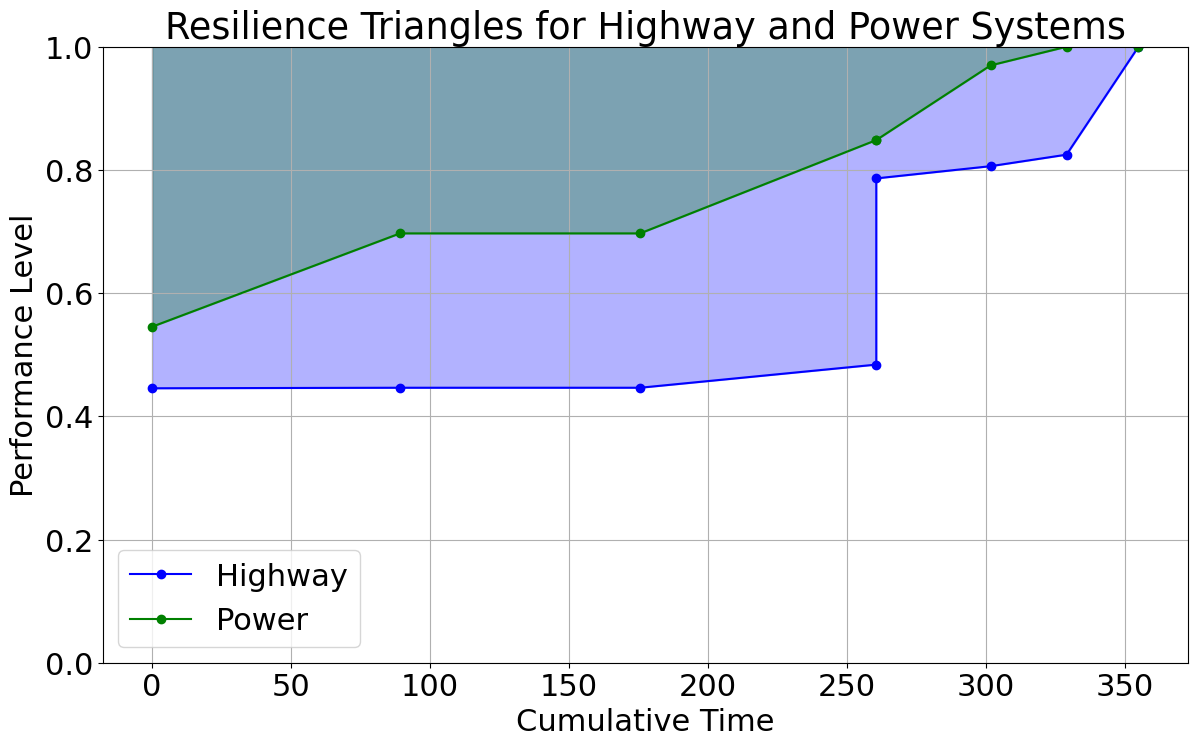

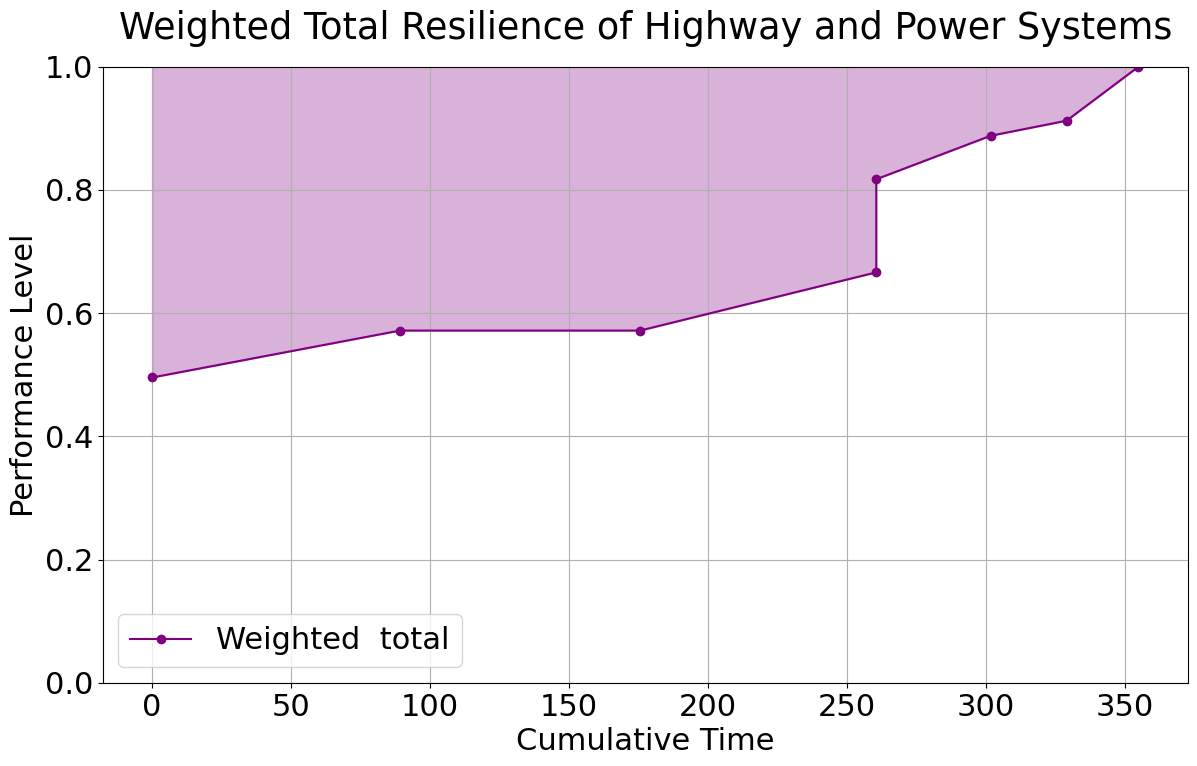

[11, 17, 15, (9, 10), 28, 32, (11, 14)]

In [7]:
run_model(sequence,True,result_folder,"This is random",'evalrand',True)   #consider default sequence as random

eval


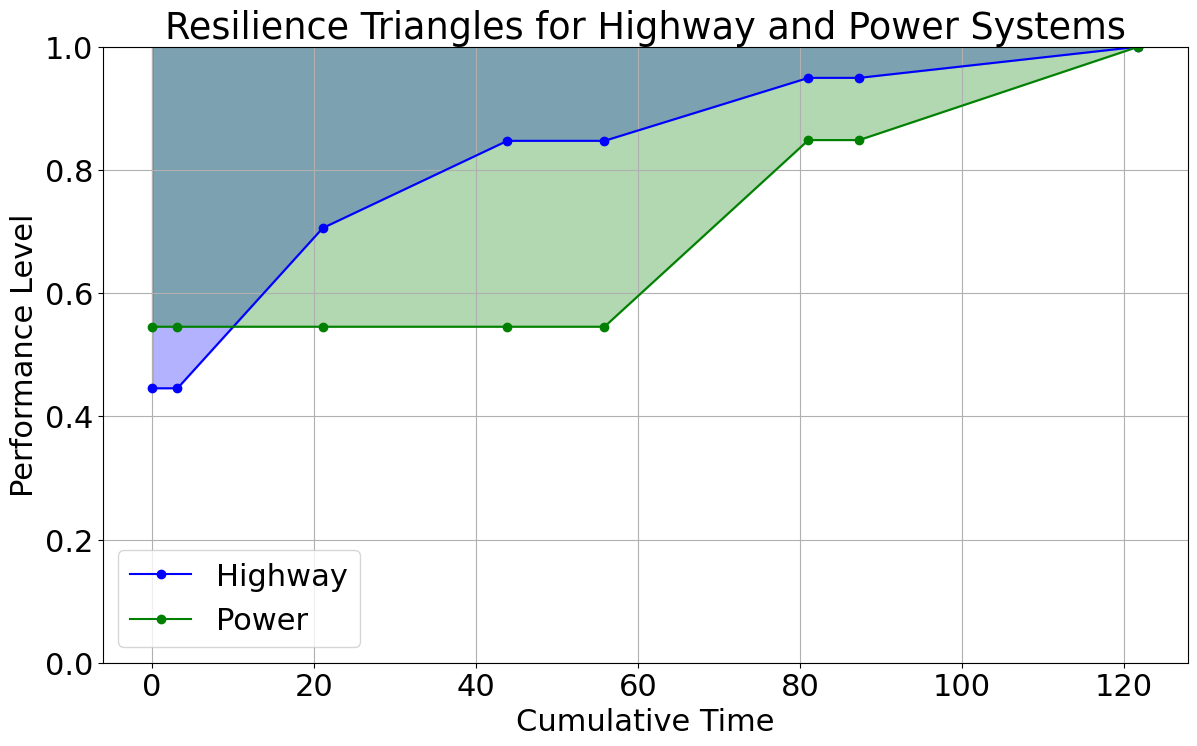

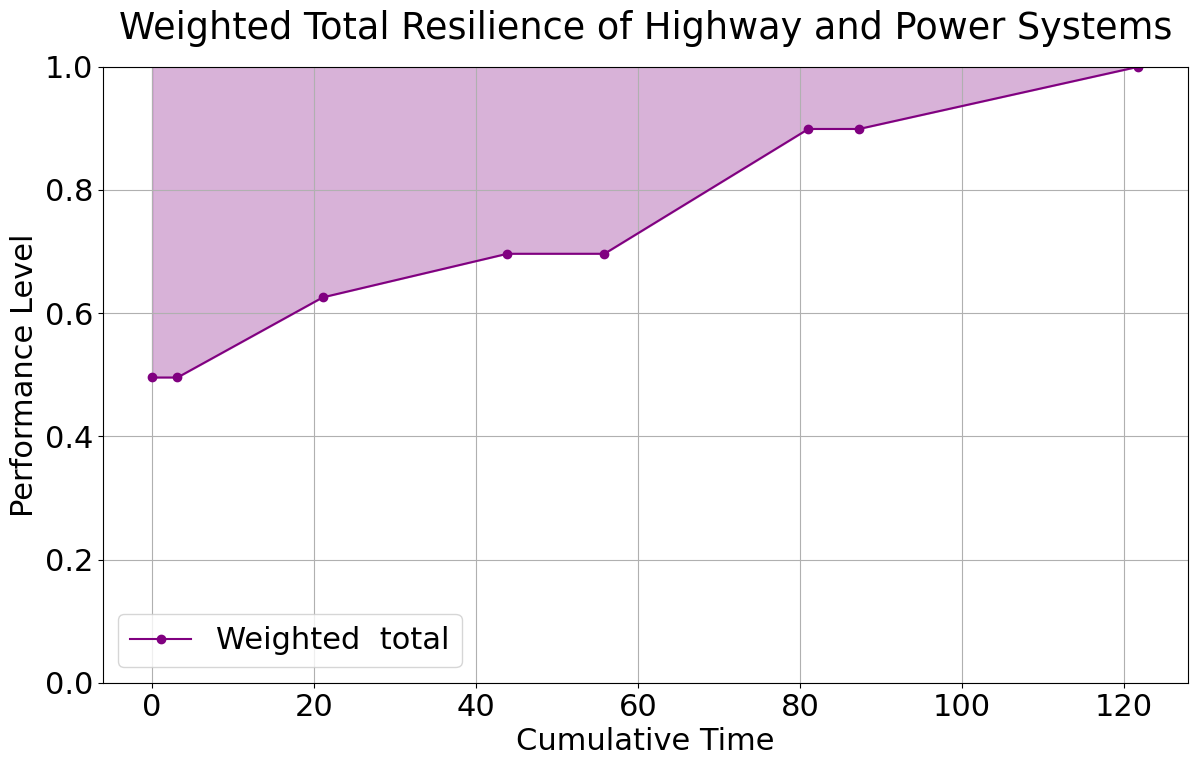

[17, (9, 10), (11, 14), 15, 11, 32, 28]

In [8]:
opt_cheat=[17, (9, 10), (11, 14), 15, 11, 32, 28]
run_model(opt_cheat,True,result_folder,"This is cheat optimal considering interdependence",'eval',True)

The following is the default model

Initial population:
[15, (11, 14), 32, 17, (9, 10), 11, 28]
[(9, 10), (11, 14), 28, 32, 15, 11, 17]
[(9, 10), 11, 17, (11, 14), 15, 32, 28]
[17, 28, (11, 14), 32, 15, 11, (9, 10)]
[17, 28, (9, 10), 11, 15, 32, (11, 14)]
gen	nevals	avg    	min                	max                  
0  	100   	161.255	(63.3739794251886,)	(348.19972463947585,)
1  	62    	112.184	(63.3739794251886,)	(279.082495128972,)  
2  	59    	96.6624	(60.3954942702769,)	(269.2487484688643,) 
3  	71    	93.5612	(56.59137007810837,)	(274.2729566566508,) 
4  	65    	72.7457	(56.59137007810837,)	(289.28698672717076,)
5  	55    	68.5332	(56.59137007810837,)	(212.97824732622936,)
6  	63    	64.7356	(56.59137007810837,)	(192.3723658604024,) 
7  	60    	65.777 	(56.59137007810837,)	(225.68419866001182,)
8  	58    	61.3257	(56.59137007810837,)	(136.14461020961983,)
9  	64    	67.8855	(56.59137007810837,)	(319.5071372044939,) 
10 	61    	59.6074	(56.59137007810837,)	(167.28145488079474,)
11 	50    	64.0345	(56.59137007810837,)	

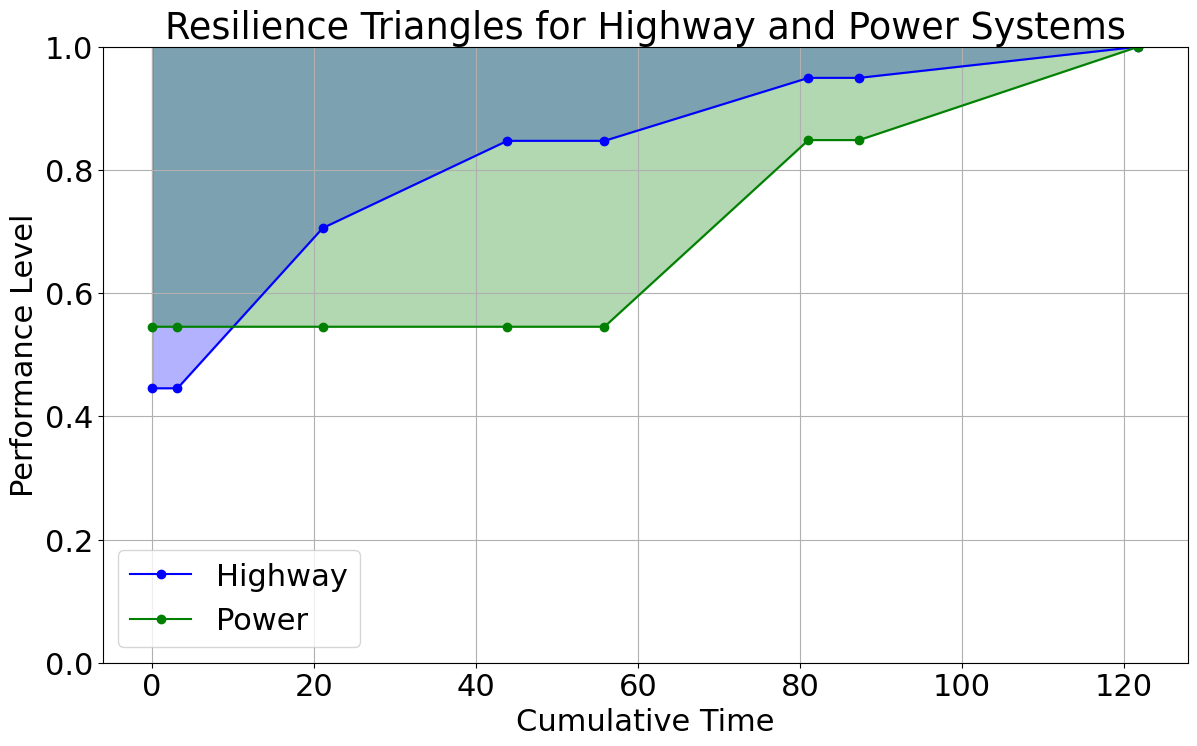

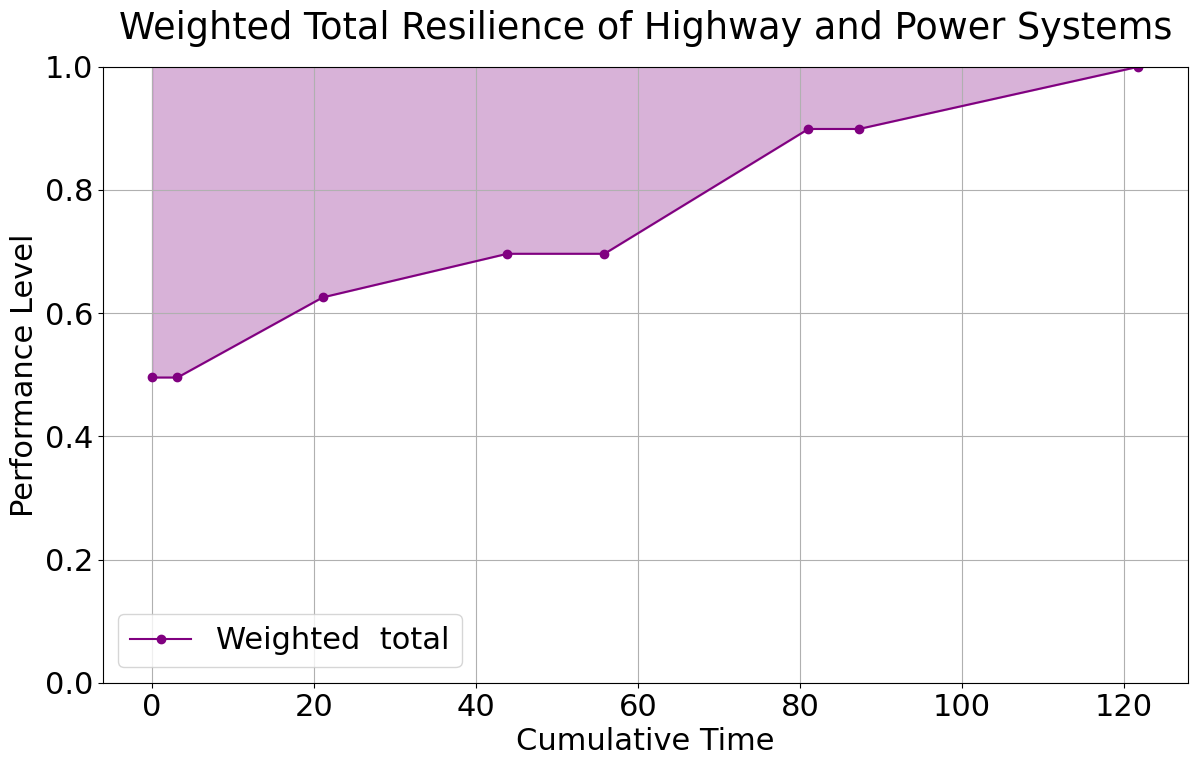

[17, (9, 10), (11, 14), 15, 11, 32, 28]

In [9]:
run_model(sequence,True,result_folder,"This is optimal considering interdependence",'opt',True)

In [10]:
powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only",'optPower',False)
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only",'optRoad',False)
road_priority=roads_ans+power_ans
power_priority=power_ans+roads_ans

Initial population:
[15, 32, 28, 11, 17]
[28, 17, 32, 15, 11]
[11, 28, 15, 32, 17]
[17, 15, 11, 32, 28]
[17, 28, 32, 15, 11]
gen	nevals	avg    	min                  	max                  
0  	100   	56.1376	(33.749758573973324,)	(101.39061354682711,)
1  	74    	44.5436	(33.749758573973324,)	(88.34800086953273,) 
2  	59    	37.0528	(33.749758573973324,)	(72.30221971594196,) 
3  	67    	35.386 	(33.749758573973324,)	(101.39061354682711,)
4  	59    	34.9719	(33.749758573973324,)	(63.8262470765265,)  
5  	63    	35.3575	(33.749758573973324,)	(94.9635984439509,)  
6  	62    	34.7129	(33.749758573973324,)	(50.8170160356698,)  
7  	62    	35.3082	(33.749758573973324,)	(67.56076457334376,) 
8  	65    	35.4545	(33.749758573973324,)	(69.52427069511502,) 
9  	60    	35.4488	(33.749758573973324,)	(94.9635984439509,)  
10 	62    	35.3681	(33.749758573973324,)	(63.8262470765265,)  
11 	62    	34.954 	(33.749758573973324,)	(50.49443152509076,) 
12 	57    	34.0885	(33.749758573973324,)	(50.49443152509

Road Priority

eval


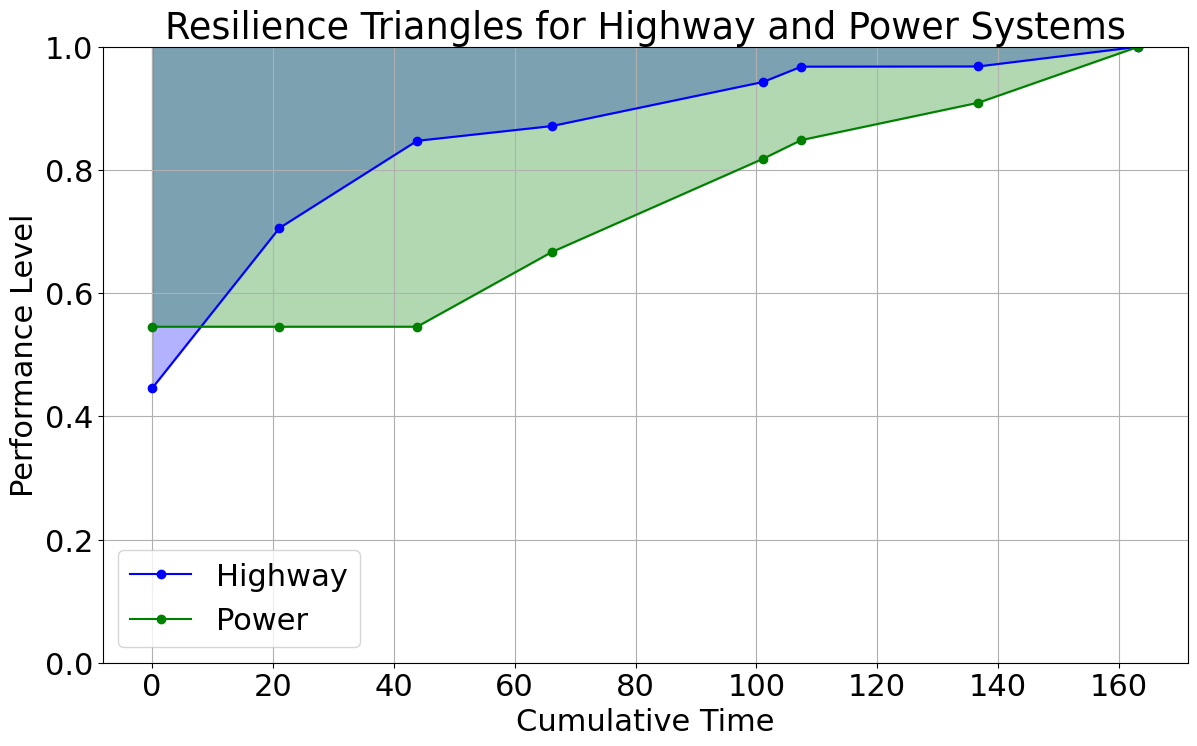

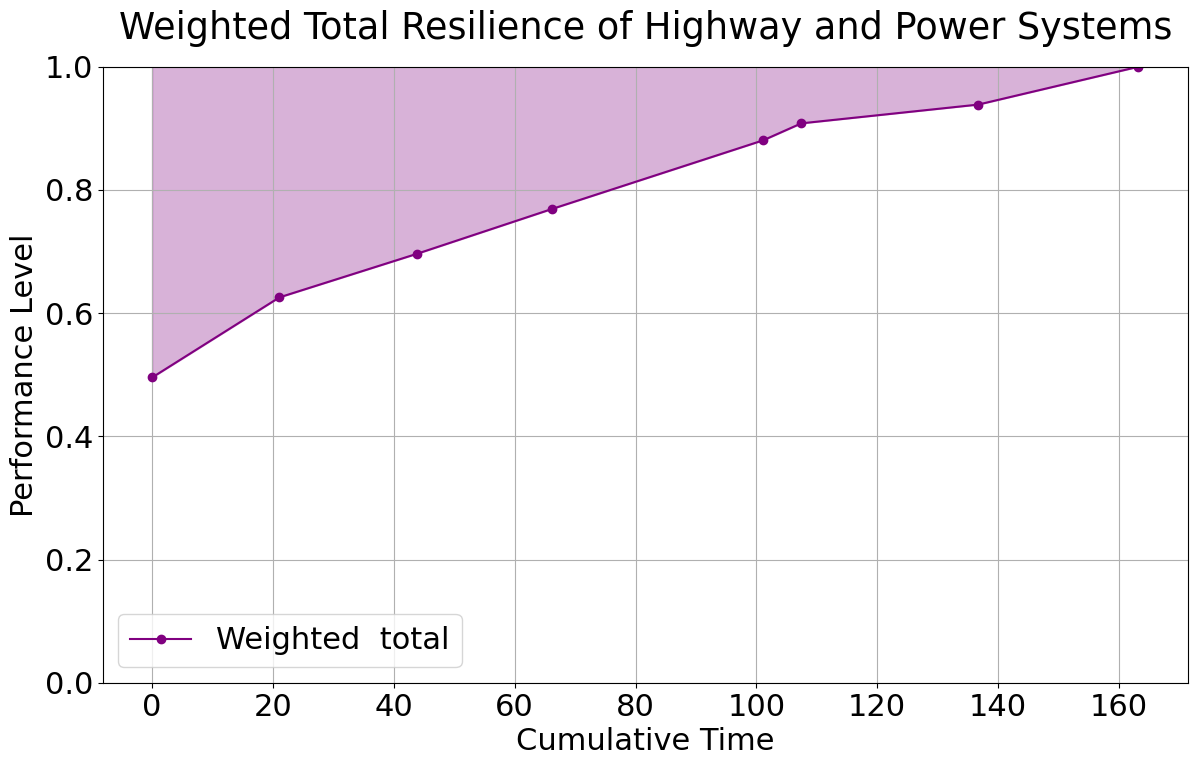

In [11]:
roads_ans=run_model(road_priority,True,result_folder,"This is Road priority",'evalRoadPriority',True)

Power Priority

eval


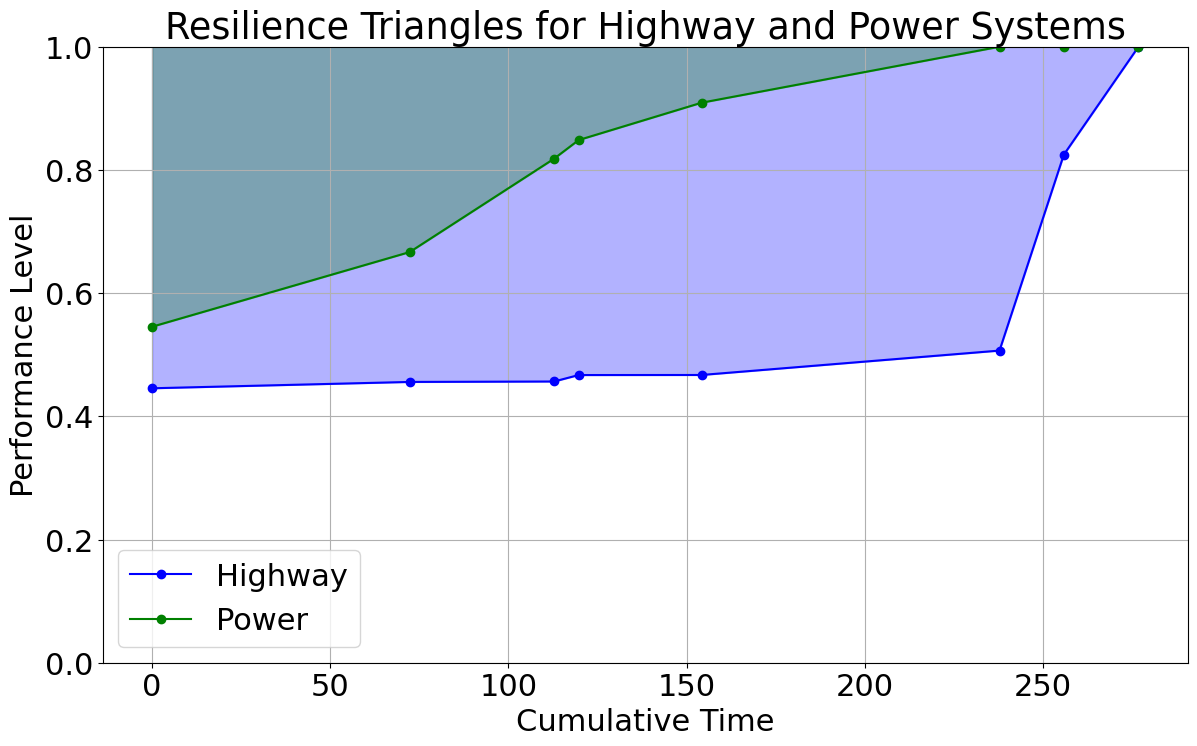

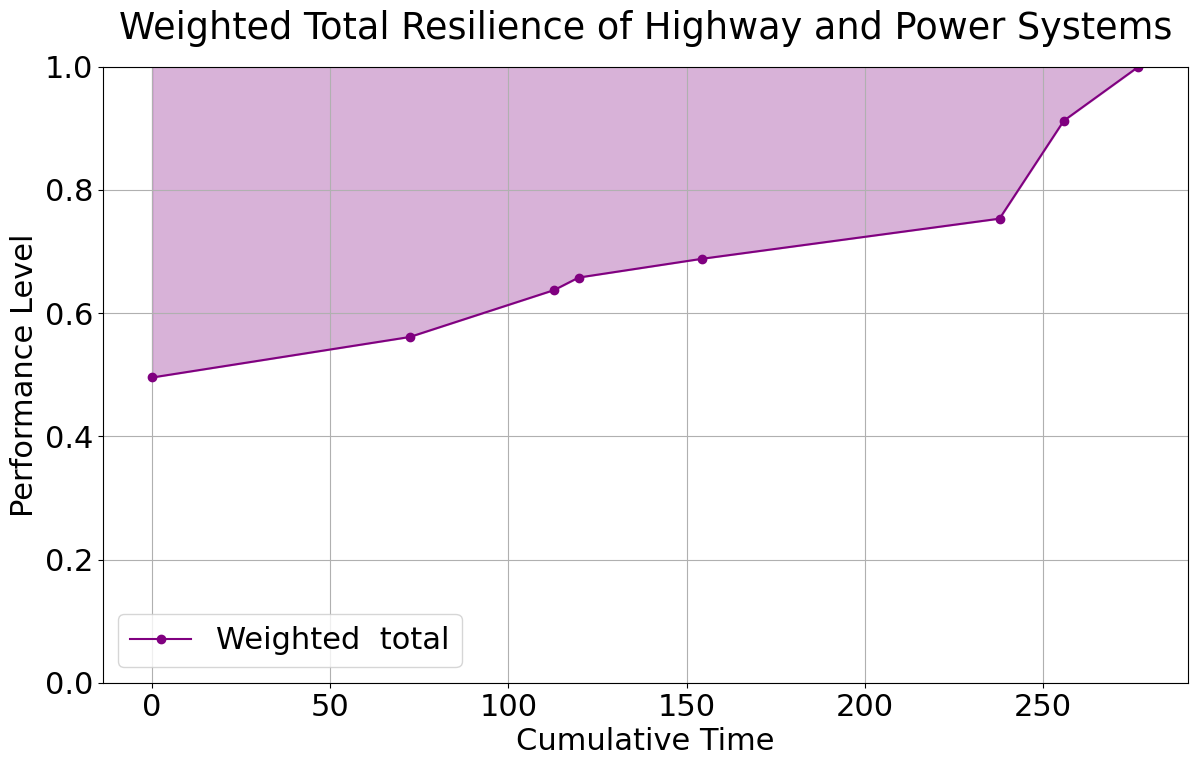

In [12]:
roads_ans=run_model(power_priority,True,result_folder,"This is Power priority",'evalPowerPriority',True)

Sensitivity design
Sensitivity #1: 
increase the number of broken links/nets

eval


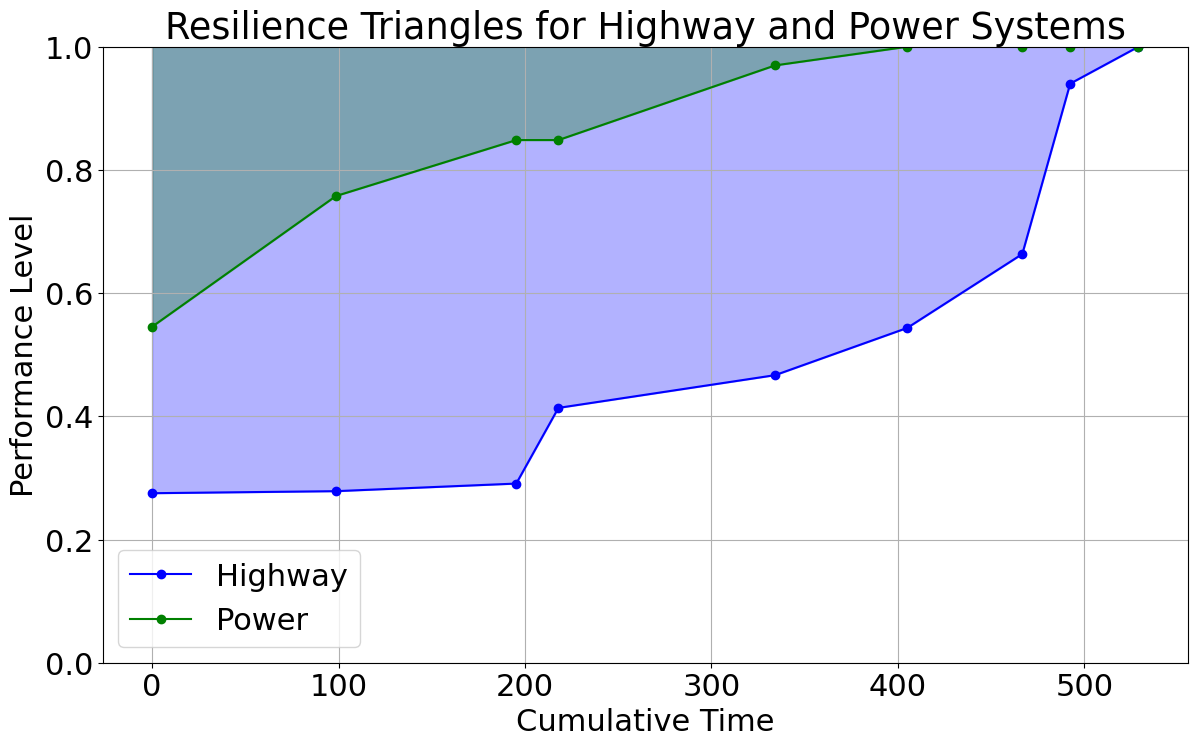

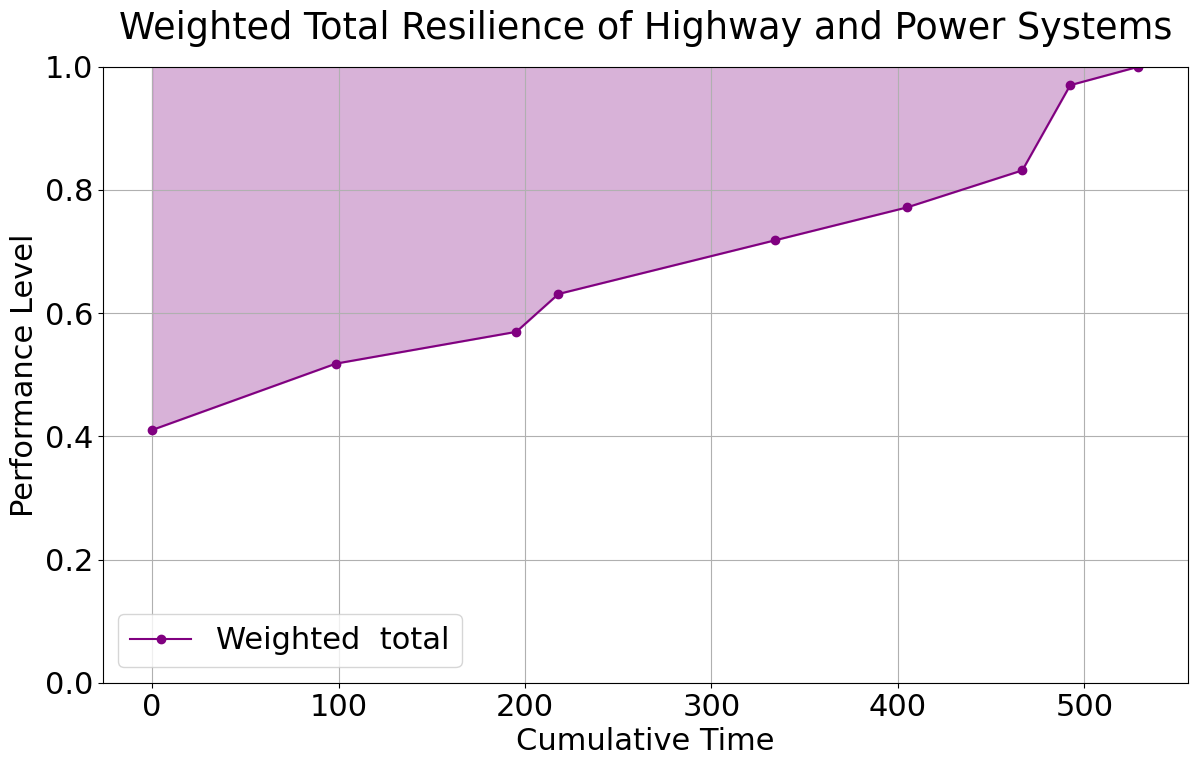

[11, 17, (9, 10), 28, 32, (11, 14), (15, 22), (2, 6)]

In [13]:
SENS1_sequence=[11,17,(9,10),28,32,(11,14),(15,22),(2,6)]
run_model(SENS1_sequence,True,result_folder,"This is random of SENSITIVITY increase breaks",'evalrandSENS1',True)

Initial population:
[(11, 14), 28, (9, 10), 11, 17, (15, 22), 32, (2, 6)]
[32, 17, (11, 14), 11, (15, 22), 28, (9, 10), (2, 6)]
[28, (2, 6), 32, (15, 22), (11, 14), (9, 10), 11, 17]
[(9, 10), 17, 32, 28, (15, 22), (2, 6), (11, 14), 11]
[(9, 10), (15, 22), 28, 32, 11, (11, 14), (2, 6), 17]
gen	nevals	avg   	min                  	max                 
0  	100   	284.99	(111.55312358748097,)	(485.2669090255406,)
1  	53    	203.425	(108.94675374989474,)	(385.2697034792632,)
2  	60    	166.739	(95.60308163779642,) 	(417.4584383801812,)
3  	55    	166.017	(85.35280944426583,) 	(406.45207516154545,)
4  	64    	129.309	(85.35280944426583,) 	(342.04131269985805,)
5  	74    	128.064	(83.47404963473957,) 	(444.65009835398575,)
6  	48    	107.858	(83.47404963473957,) 	(341.93177937679616,)
7  	55    	99.7864	(83.47404963473957,) 	(277.34128470813357,)
8  	57    	97.7646	(83.47404963473957,) 	(317.1479885021316,) 
9  	69    	106.616	(83.47404963473957,) 	(444.84935449954014,)
10 	62    	98.3117	(83.

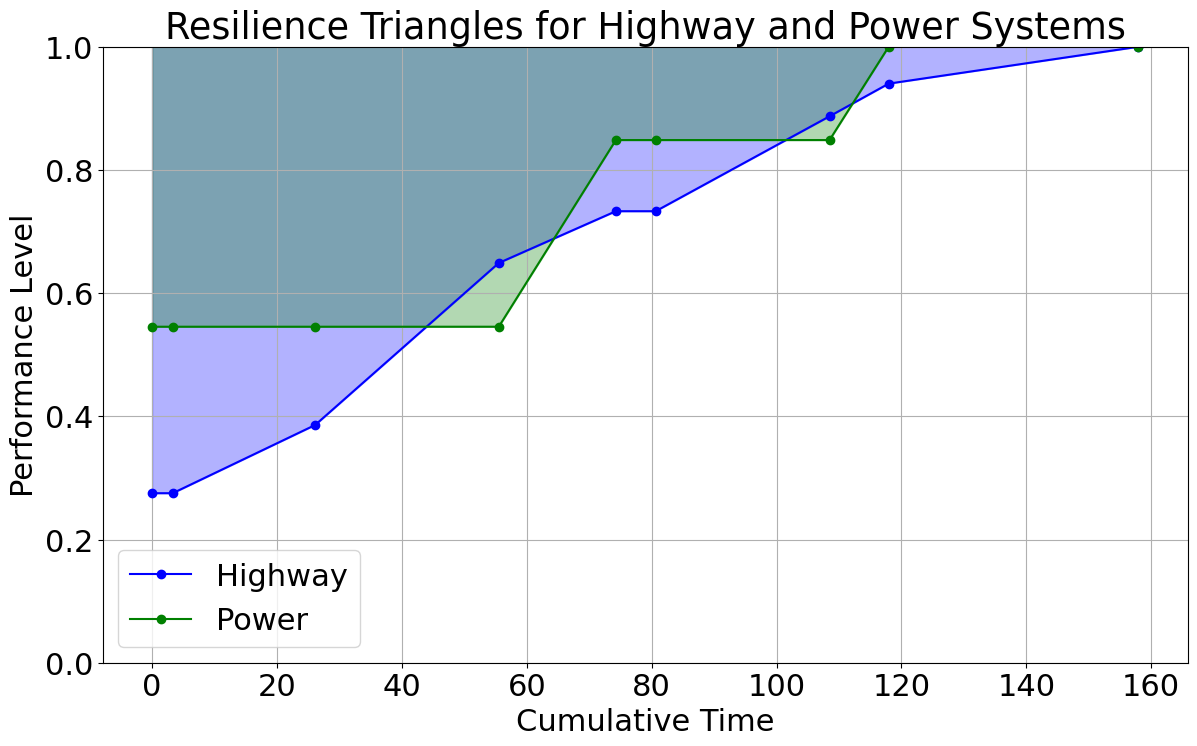

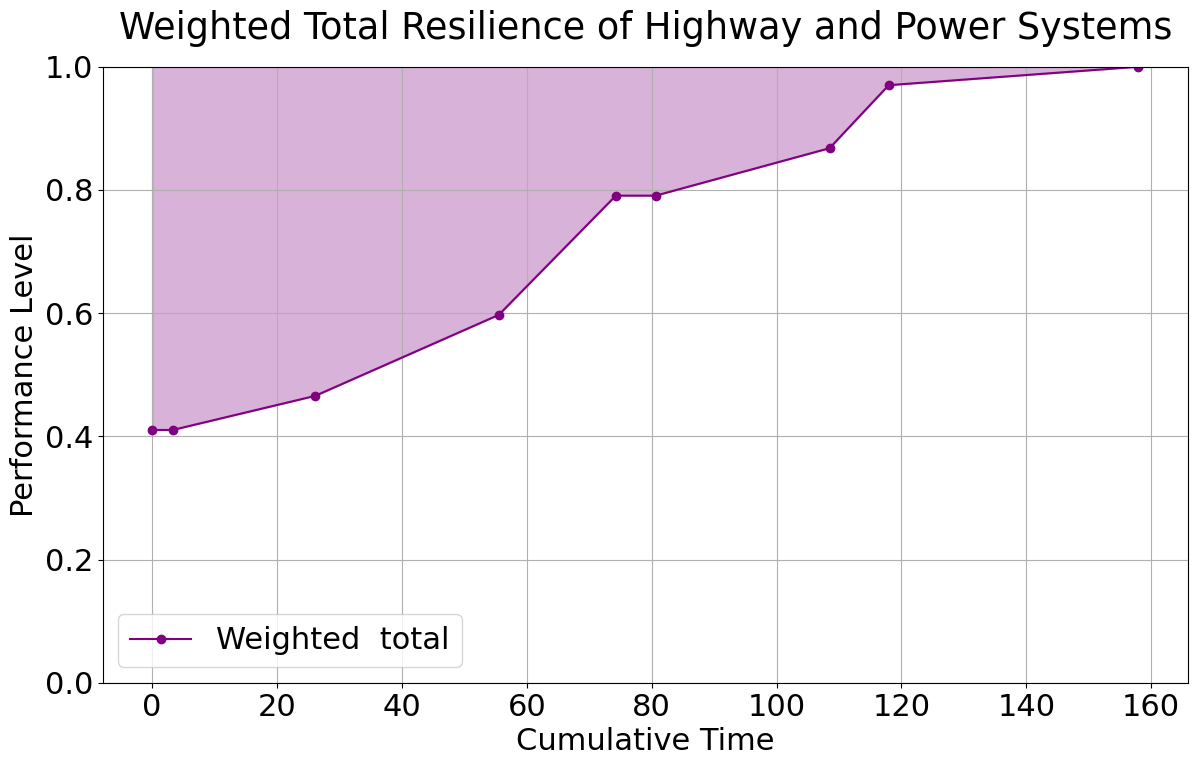

[17, (9, 10), (15, 22), 11, 32, (11, 14), 28, (2, 6)]

In [14]:
run_model(SENS1_sequence,True,result_folder,"This is SENSITIVITY increase breaks",'SENS1',True)

In [15]:

powers_only_sens1=[11,17,28,32]
roads_only_sens1=[(9,10),(11,14),(15,22),(2,6)]
power_ans_sens1=run_model(powers_only_sens1,True,result_folder,"This is optimal Power only SENS1",'optPowerSENS1',False)
roads_ans_sens1=run_model(roads_only_sens1,True,result_folder,"This is optimal Road only SENS1",'optRoadSENS1',False)
power_priority_sens1=power_ans_sens1+roads_ans_sens1
road_priority_sens1=roads_ans_sens1+power_ans_sens1

Initial population:
[11, 17, 28, 32]
[28, 11, 32, 17]
[28, 17, 11, 32]
[11, 32, 28, 17]
[17, 28, 32, 11]
gen	nevals	avg    	min               	max                 
0  	100   	44.7932	(26.079454345436,)	(82.53552808578978,)
1  	56    	30.575 	(26.079454345436,)	(67.89389639919582,)
2  	59    	27.6928	(26.079454345436,)	(56.2079988171745,) 
3  	52    	28.0143	(26.079454345436,)	(55.64318546404142,)
4  	63    	27.4512	(26.079454345436,)	(67.89389639919582,)
5  	67    	27.1474	(26.079454345436,)	(47.86991559337587,)
6  	56    	27.3484	(26.079454345436,)	(48.94304258429474,)
7  	54    	26.7543	(26.079454345436,)	(47.86991559337587,)
8  	64    	27.8823	(26.079454345436,)	(82.53552808578978,)
9  	59    	27.1832	(26.079454345436,)	(67.89389639919582,)
10 	68    	27.1613	(26.079454345436,)	(47.86991559337587,)
11 	61    	26.3357	(26.079454345436,)	(38.74660411803129,)
12 	59    	27.3202	(26.079454345436,)	(55.64318546404142,)
13 	57    	26.9866	(26.079454345436,)	(47.86991559337587,)
14 	67    

eval


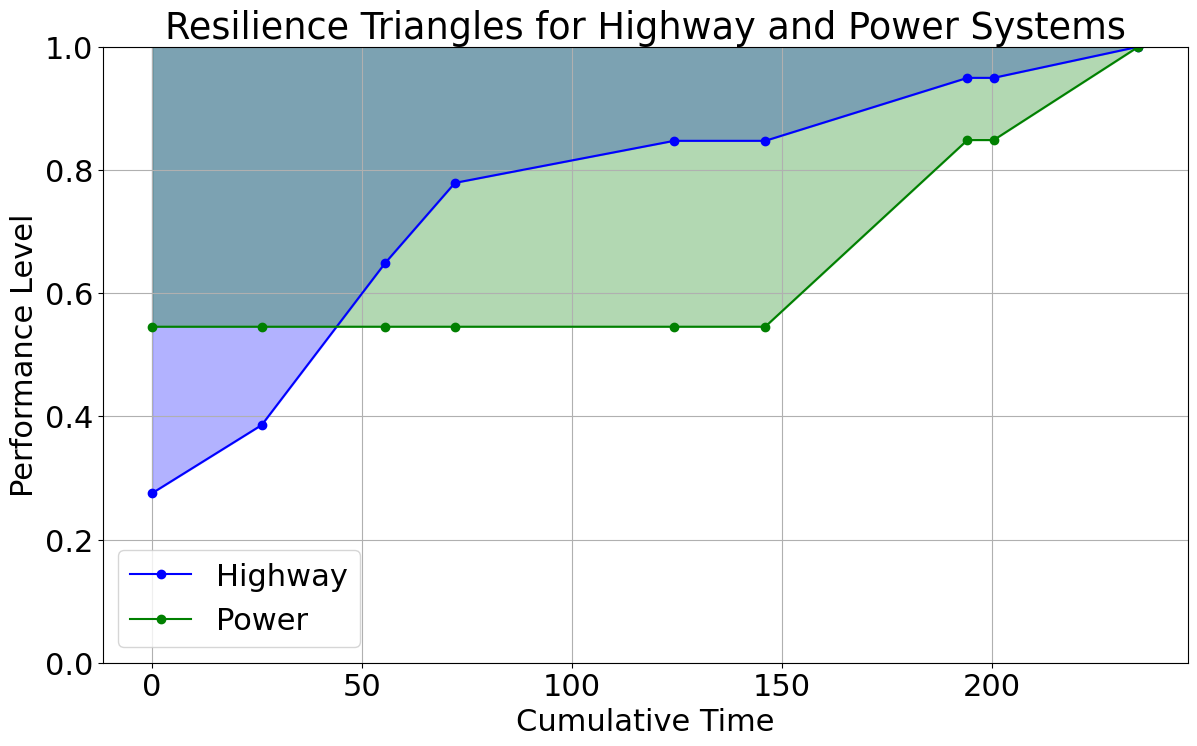

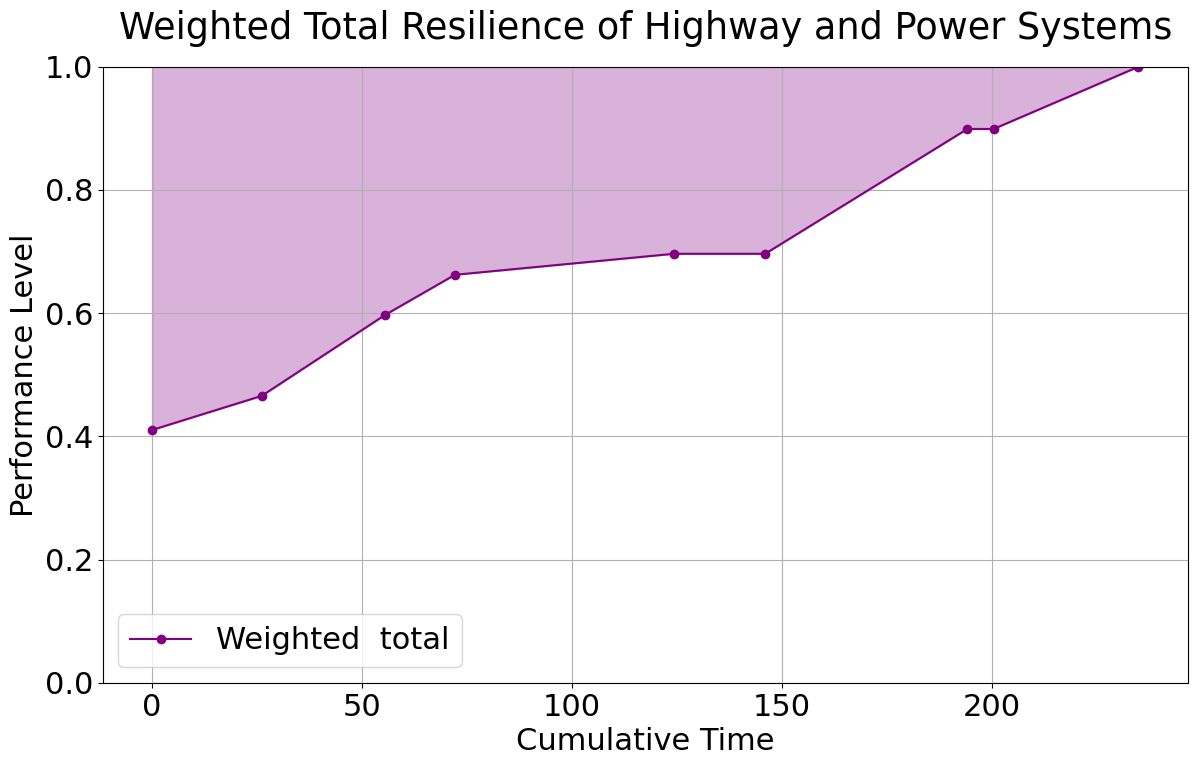

[(9, 10), (15, 22), (11, 14), (2, 6), 17, 11, 32, 28]

In [16]:

run_model(road_priority_sens1,True,result_folder,"This is Road priority SENS1",'evalRoadPrioritySENS1',True)

eval


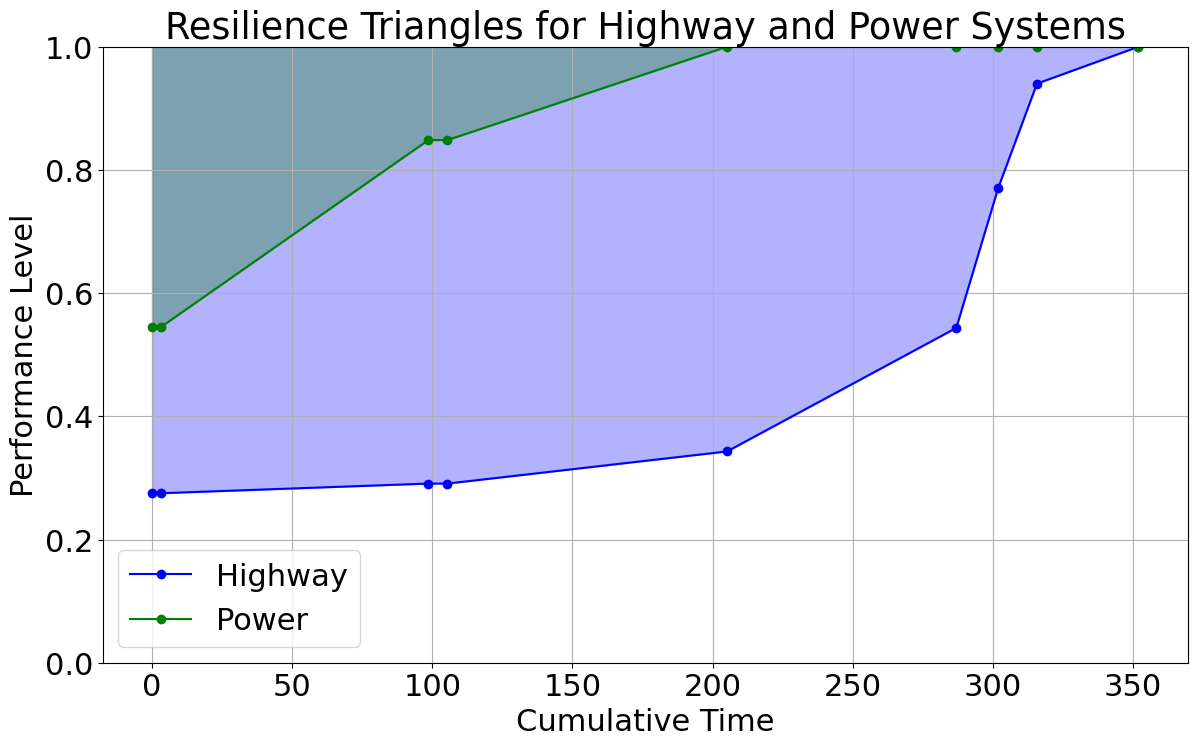

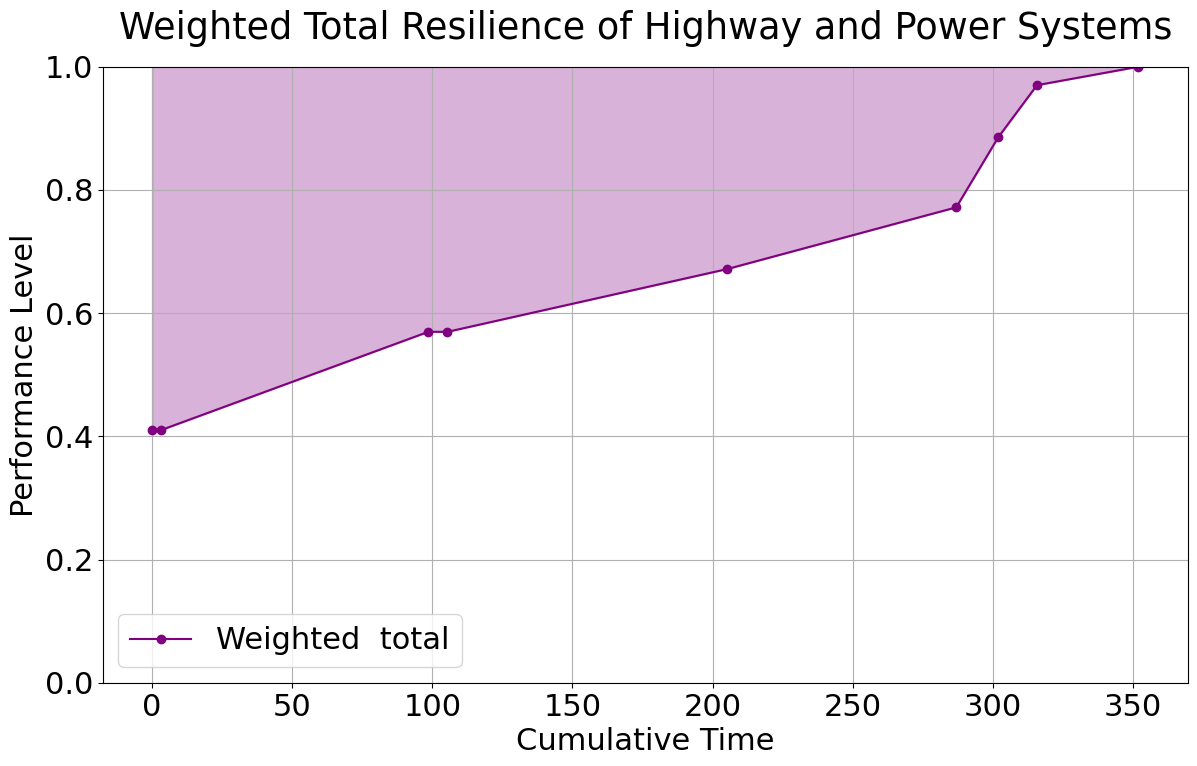

[17, 11, 32, 28, (9, 10), (15, 22), (11, 14), (2, 6)]

In [17]:

run_model(power_priority_sens1,True,result_folder,"This is Power priority SENS1",'evalPowerPrioritySENS1',True)

Sensitivity#2:
move the connection points around

Initial population:
[17, (11, 14), 28, 11, 15, (9, 10), 32]
[28, 32, 11, (11, 14), 17, 15, (9, 10)]
[11, (9, 10), (11, 14), 28, 15, 32, 17]
[17, 28, 32, 11, (9, 10), (11, 14), 15]
[15, (11, 14), 11, 17, 28, 32, (9, 10)]
gen	nevals	avg  	min                  	max                 
0  	100   	170.6	(63.435163577159145,)	(367.5560777752072,)
1  	63    	110.301	(55.46234293184425,) 	(315.6312425618856,)
2  	59    	98.3189	(51.573400347708045,)	(325.5143347664656,)
3  	61    	73.4588	(50.23489863355882,) 	(215.32426262674446,)
4  	58    	61.2508	(50.23489863355882,) 	(224.21179285112424,)
5  	59    	71.4723	(49.32259905871119,) 	(267.3674148132405,) 
6  	56    	61.8487	(49.32259905871119,) 	(305.75016991718877,)
7  	58    	65.0112	(49.32259905871119,) 	(178.75760440138112,)
8  	58    	57.1885	(49.32259905871119,) 	(196.50275976780176,)
9  	53    	64.2096	(49.32259905871119,) 	(193.56929523995774,)
10 	70    	58.3604	(49.32259905871119,) 	(195.38162513219777,)
11 	63    	56.2069	(49.322599058

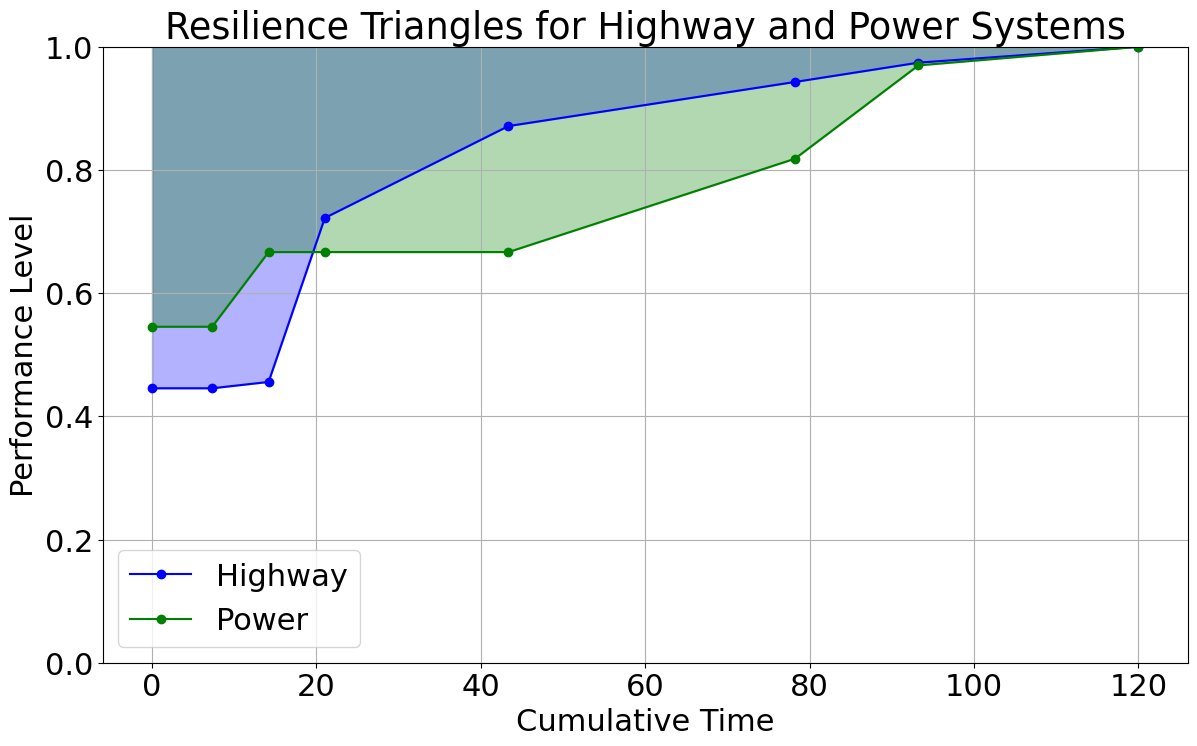

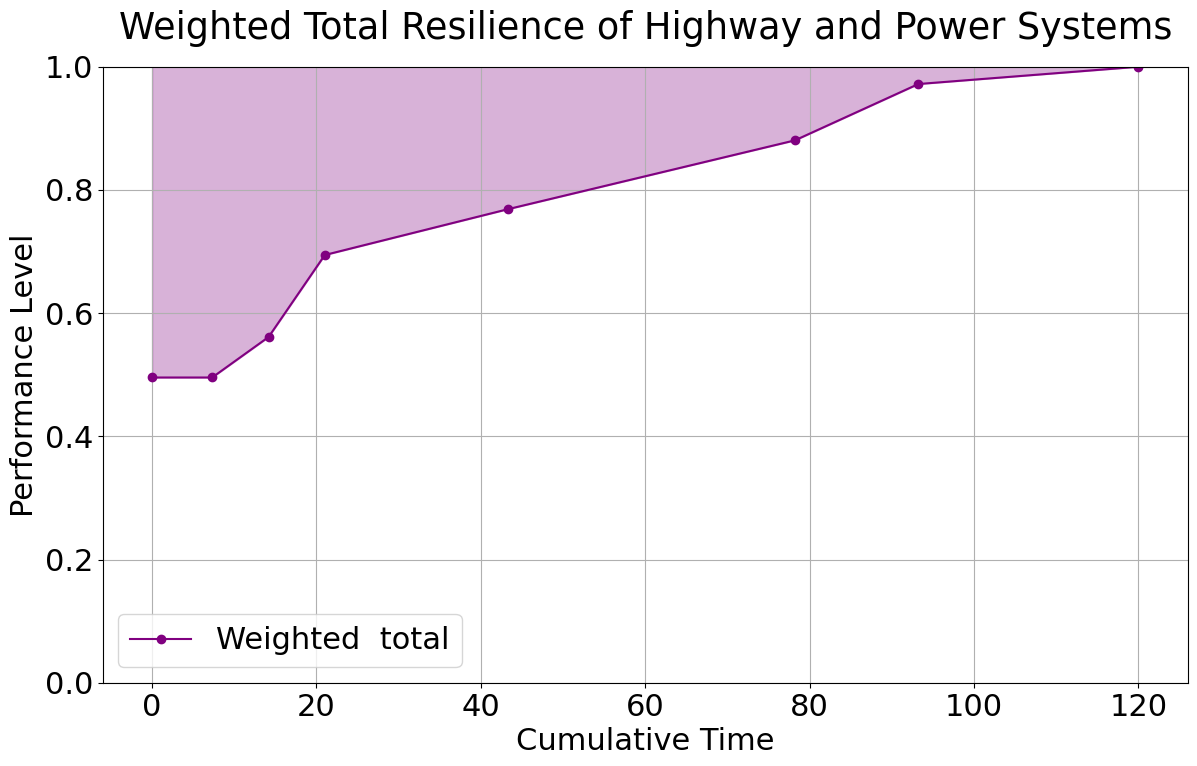

[17, 28, (9, 10), (11, 14), 11, 15, 32]

In [18]:
run_model(sequence,True,result_folder,"This is SENSITIVITY #2, move connections around",'SENS2',True)

In [19]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS2",'optPowerSENS2',False)
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS2",'optRoadSENS2',False)

Initial population:
[17, 28, 32, 15, 11]
[28, 32, 17, 15, 11]
[11, 17, 28, 15, 32]
[28, 32, 15, 11, 17]
[32, 15, 11, 28, 17]
gen	nevals	avg   	min                  	max                  
0  	100   	57.265	(33.749758573973324,)	(101.39061354682711,)
1  	65    	44.2481	(33.749758573973324,)	(94.41353727166454,) 
2  	65    	37.8037	(33.749758573973324,)	(88.34800086953273,) 
3  	74    	35.5965	(33.749758573973324,)	(72.12808954166967,) 
4  	55    	35.243 	(33.749758573973324,)	(72.12808954166967,) 
5  	60    	36.3088	(33.749758573973324,)	(94.9635984439509,)  
6  	64    	35.7228	(33.749758573973324,)	(72.12808954166967,) 
7  	60    	34.7945	(33.749758573973324,)	(60.17281804984882,) 
8  	63    	35.4852	(33.749758573973324,)	(54.33353292883777,) 
9  	68    	35.3782	(33.749758573973324,)	(66.69319447792861,) 
10 	74    	35.4155	(33.749758573973324,)	(94.9635984439509,)  
11 	64    	35.867 	(33.749758573973324,)	(94.41353727166454,) 
12 	54    	35.0611	(33.749758573973324,)	(63.8262470765265

eval


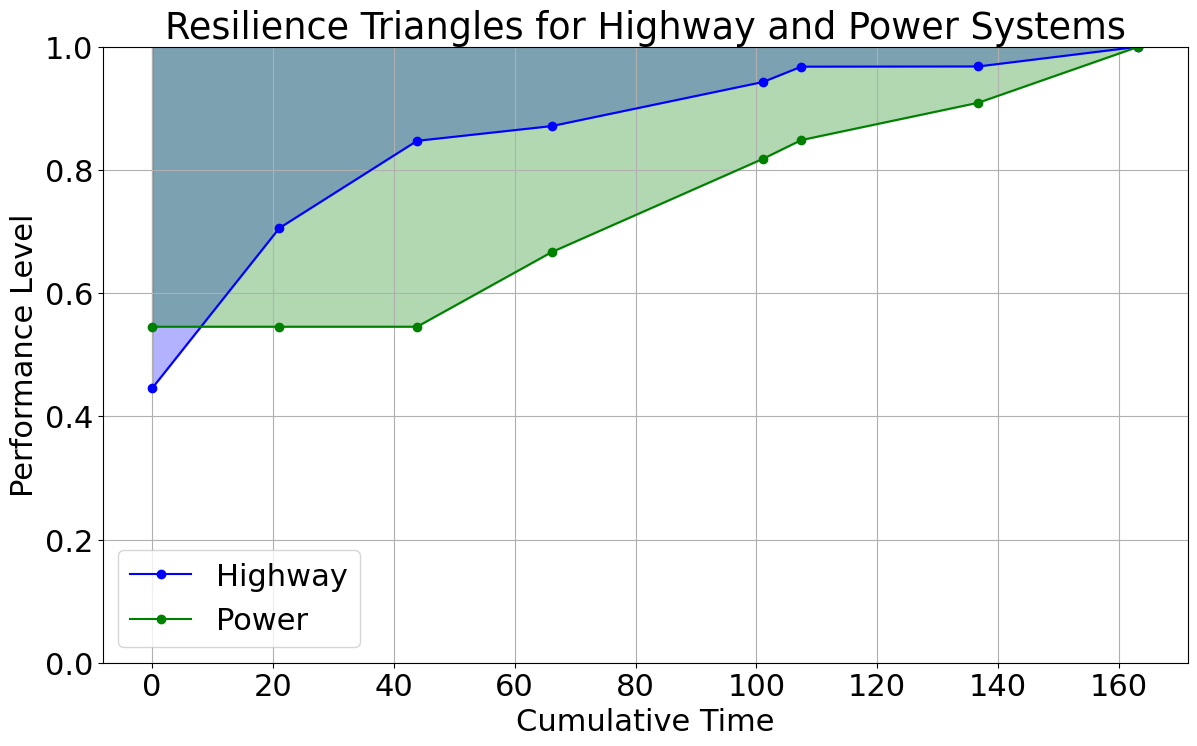

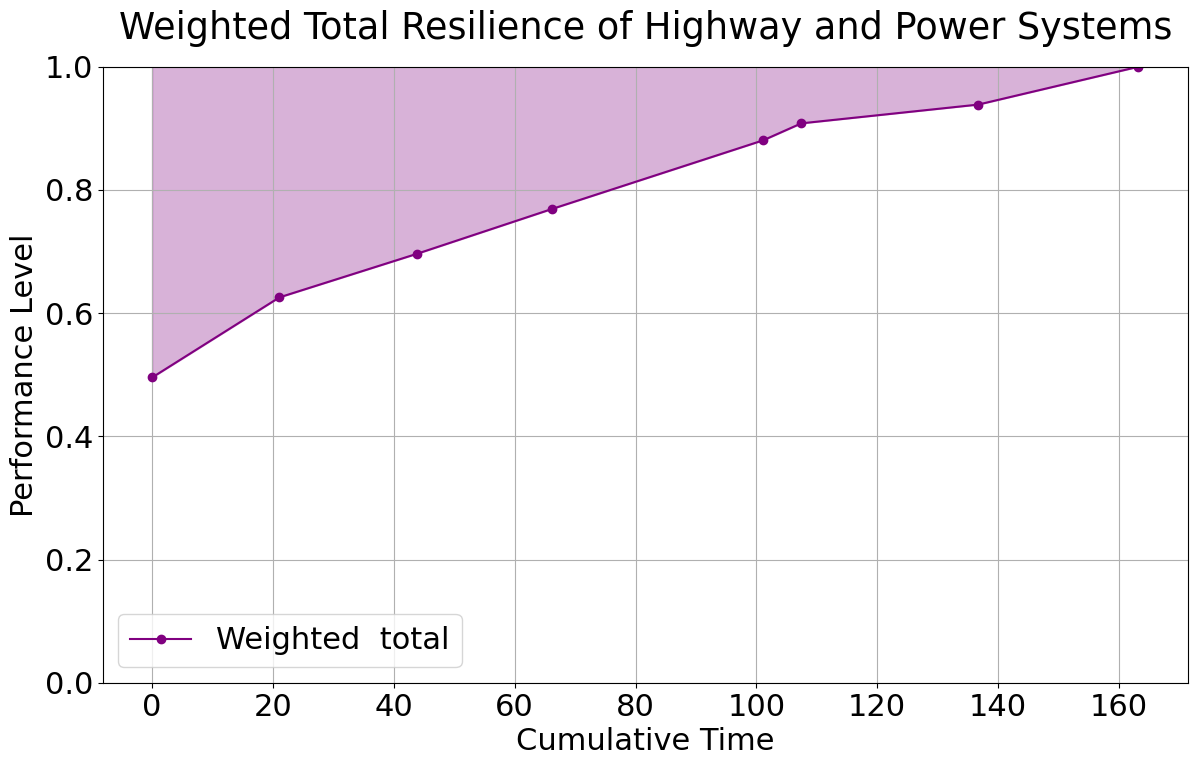

[(9, 10), (11, 14), 28, 11, 32, 15, 17]

In [20]:
run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS2",'evalRoadPrioritySENS2',True)

eval


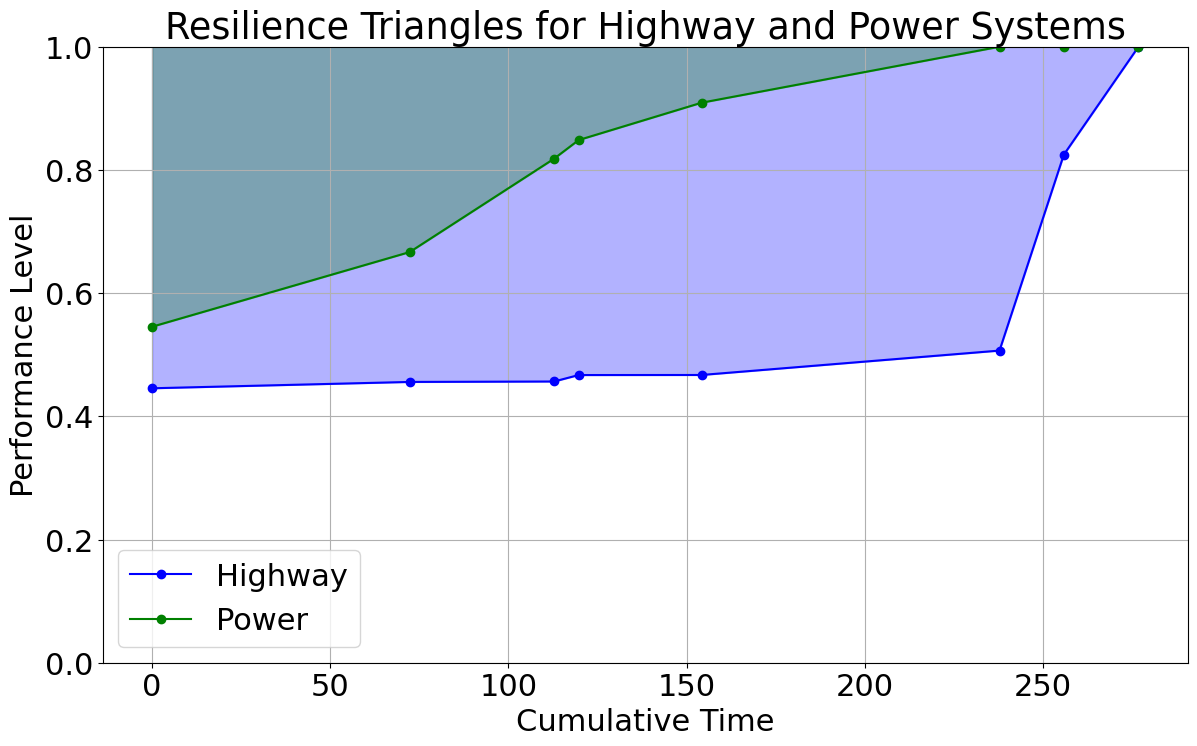

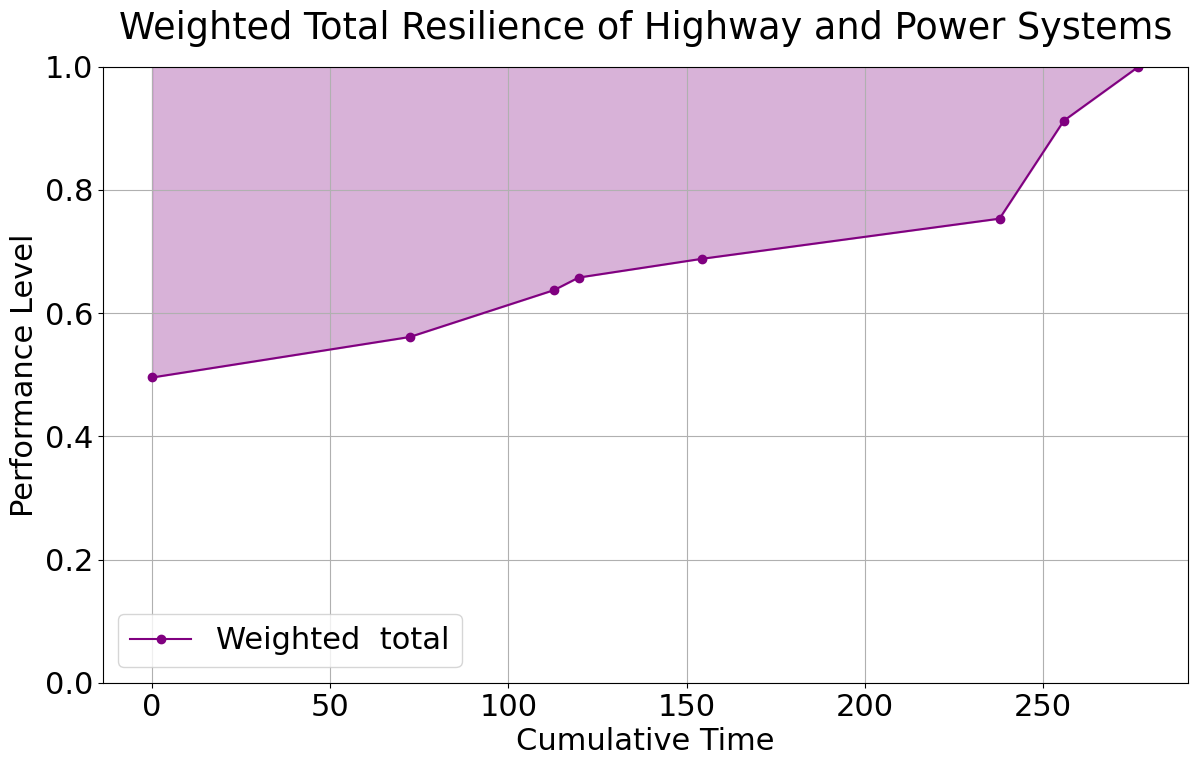

[28, 11, 32, 15, 17, (9, 10), (11, 14)]

In [21]:
run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS2",'evalPowerPrioritySENS2',True)


Sensitivity #3
different harm level for broken net or power fail (interdependency level)

Initial population:
[17, (9, 10), 15, 32, (11, 14), 28, 11]
[28, (11, 14), 15, (9, 10), 32, 17, 11]
[28, 11, 17, 32, 15, (9, 10), (11, 14)]
[15, 17, 28, (9, 10), (11, 14), 32, 11]
[28, 11, (11, 14), 32, (9, 10), 17, 15]
gen	nevals	avg    	min                 	max                 
0  	100   	197.789	(87.36647173016473,)	(373.2320182691524,)
1  	58    	142.111	(85.46459635653466,)	(345.9099403026596,)
2  	70    	118.708	(85.46459635653466,)	(283.3839706521555,)
3  	64    	112.863	(85.20644556952635,)	(355.2264668111317,)
4  	60    	105.753	(85.20644556952635,)	(355.2264668111317,)
5  	75    	110.839	(85.12143188734055,)	(358.2020792525462,)
6  	53    	103.073	(85.12143188734055,)	(358.2020792525462,)
7  	54    	92.6538	(81.22336261133634,)	(236.0783838152919,)
8  	65    	90.8933	(81.22336261133634,)	(189.55961962058882,)
9  	68    	102.794	(81.22336261133634,)	(211.22470902556125,)
10 	59    	97.2153	(81.22336261133634,)	(234.79810675108803,)
11 	70    	97.0675	(81.22336261133634,)	(295.

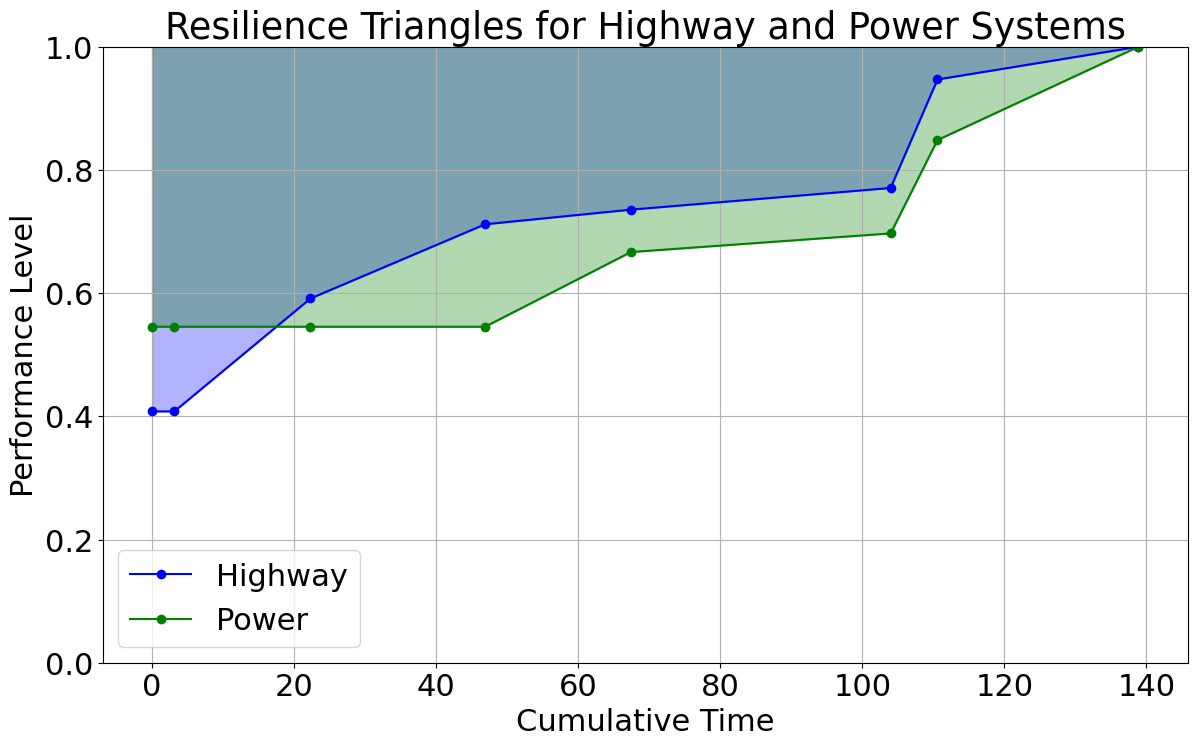

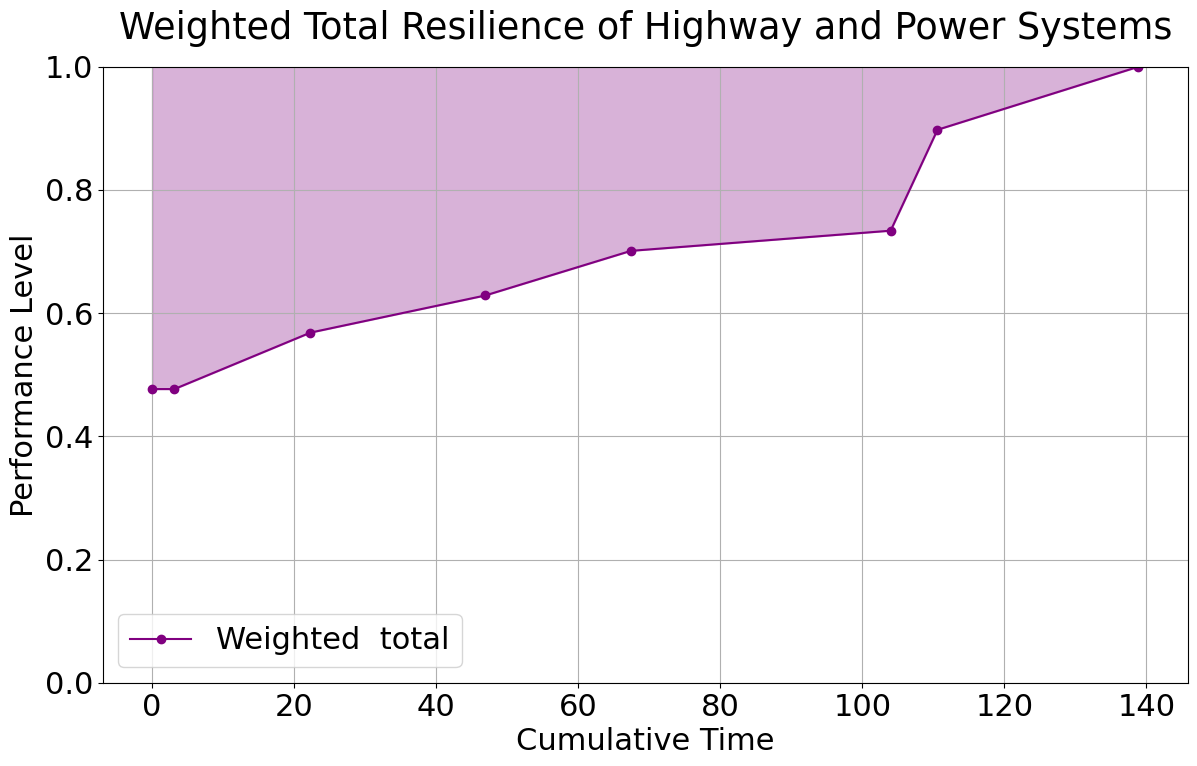

[17, (9, 10), (11, 14), 28, 32, 11, 15]

In [22]:
power_road_factor=0.3 #the lower of this the more severe the damage is
run_model(sequence,True,result_folder,"This is SENSITIVITY #3, harm level increase",'SENS3',True)


In [23]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS3",'optPowerSENS3',False)
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS3",'optRoadSENS3',False)


Initial population:
[32, 11, 28, 15, 17]
[15, 17, 32, 28, 11]
[15, 17, 11, 28, 32]
[17, 15, 28, 32, 11]
[28, 11, 15, 17, 32]
gen	nevals	avg   	min                 	max                  
0  	100   	81.914	(49.83593074057448,)	(140.77560992343288,)
1  	78    	65.214	(48.28460519164955,)	(128.5509672679912,) 
2  	67    	55.4245	(48.28460519164955,)	(90.95389292129764,) 
3  	62    	54.694 	(48.28460519164955,)	(95.69413527548603,) 
4  	61    	52.2798	(48.28460519164955,)	(98.38207474460037,) 
5  	61    	51.3807	(48.28460519164955,)	(135.47887045826795,)
6  	66    	50.7434	(48.28460519164955,)	(94.82749074912113,) 
7  	52    	50.1036	(48.28460519164955,)	(94.86138197606297,) 
8  	63    	49.4966	(48.28460519164955,)	(66.81367990954521,) 
9  	64    	51.6023	(48.28460519164955,)	(129.63116048009098,)
10 	62    	50.3513	(48.28460519164955,)	(130.45914561188764,)
11 	71    	52.0053	(48.28460519164955,)	(94.82749074912113,) 
12 	57    	49.3771	(48.28460519164955,)	(83.70001837117226,) 
13 	53    

eval


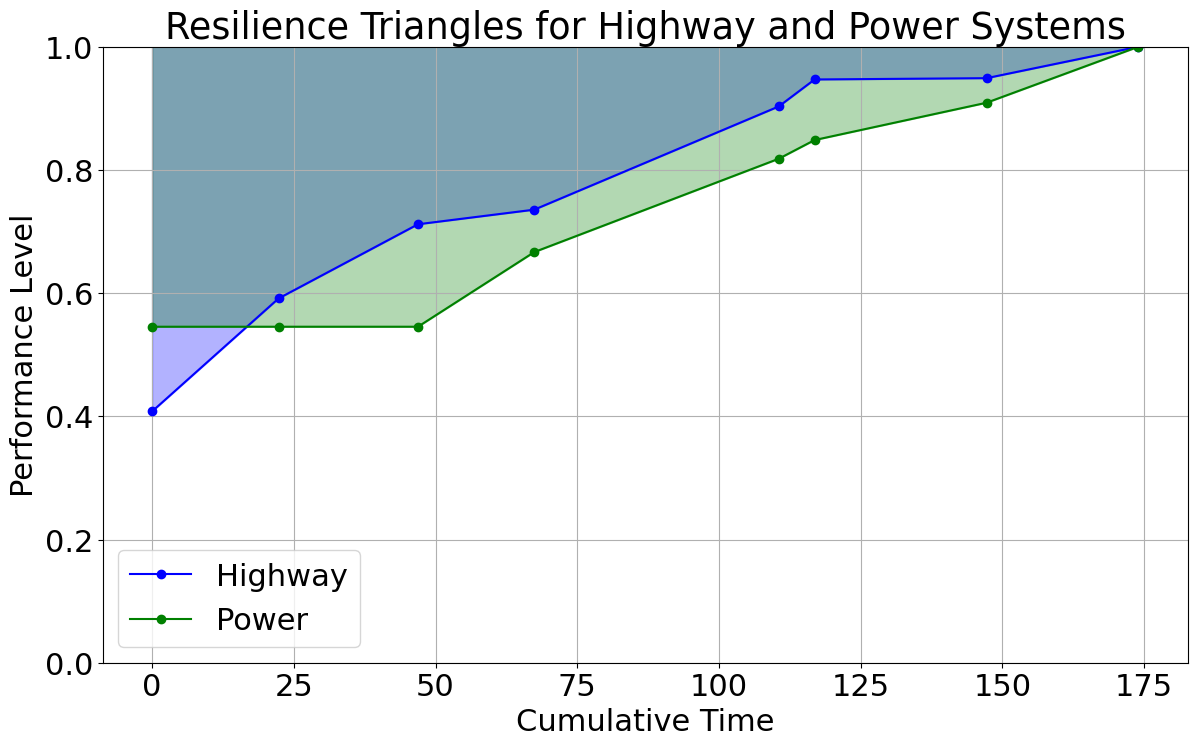

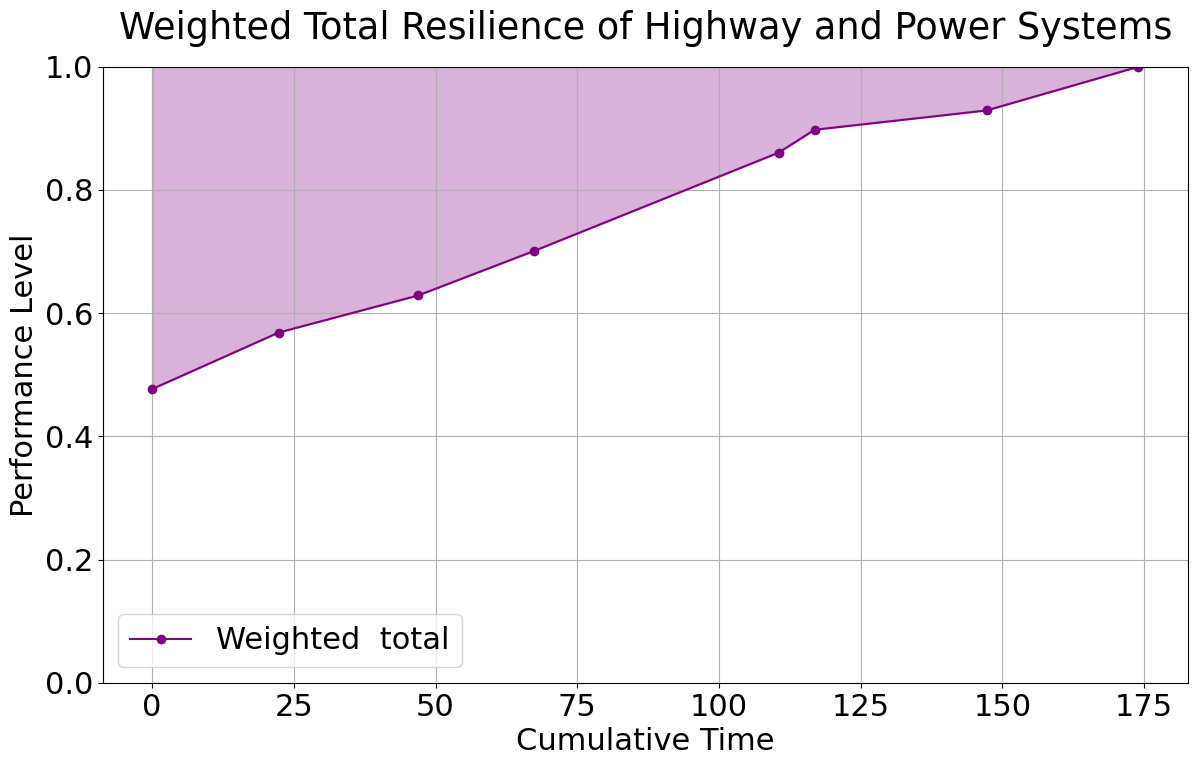

[(9, 10), (11, 14), 28, 11, 32, 15, 17]

In [24]:
run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS3",'evalRoadPrioritySENS3',True)

eval


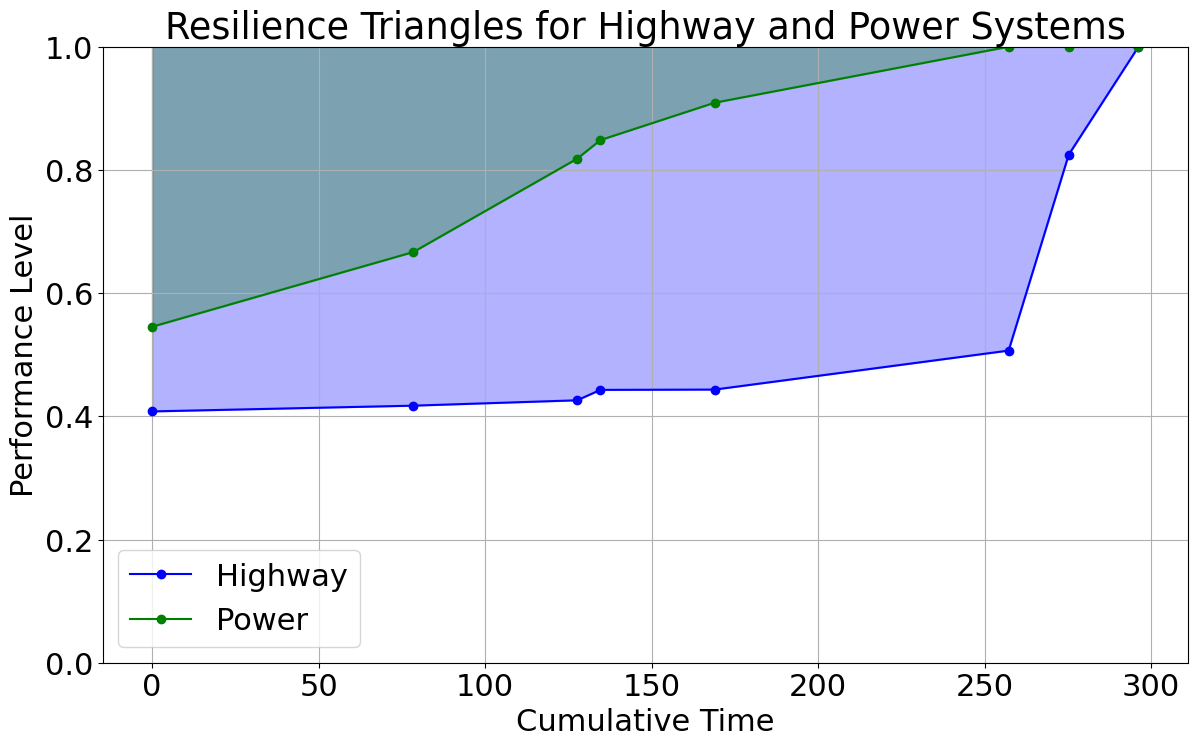

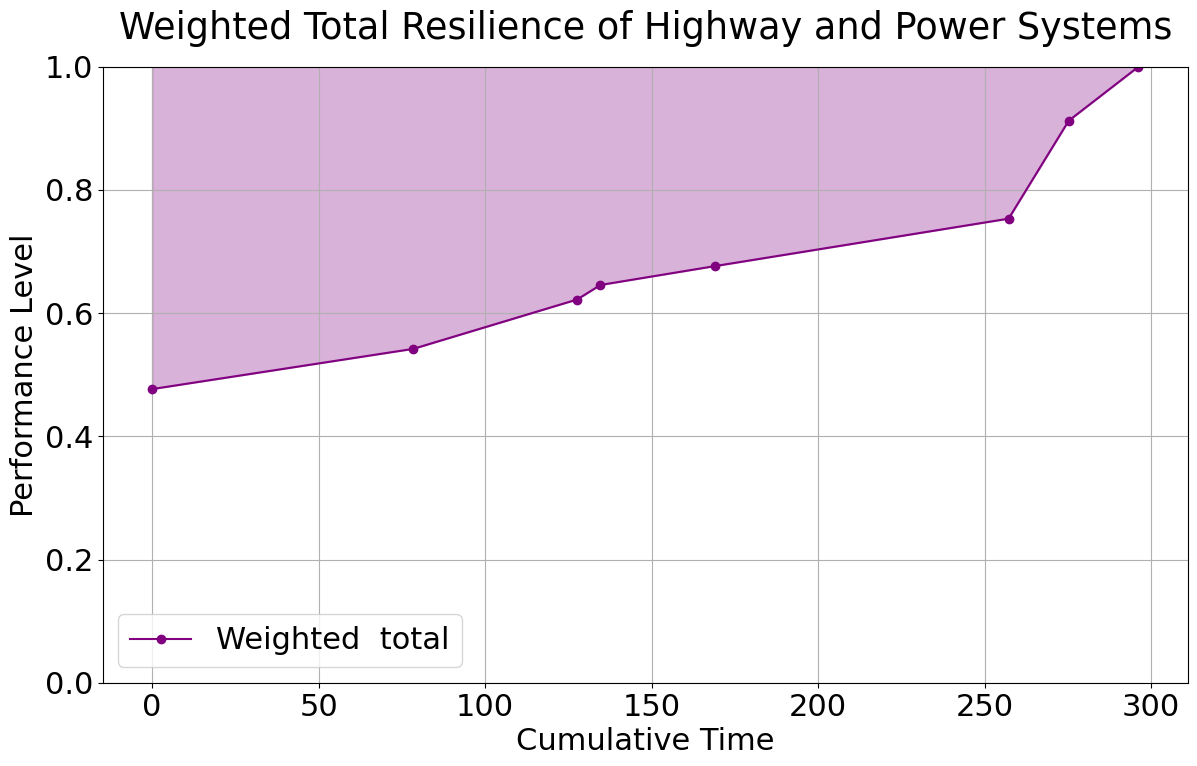

[28, 11, 32, 15, 17, (9, 10), (11, 14)]

In [25]:
run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS3",'evalPowerPrioritySENS3',True)

In [26]:
power_road_factor=0.5

Sensitivity #4
Interdependency Pattern like where the interdependenct location is

Initial population:
[11, (11, 14), (9, 10), 15, 32, 17, 28]
[32, (9, 10), 15, 11, (11, 14), 28, 17]
[28, 32, (9, 10), 15, 17, 11, (11, 14)]
[32, 17, (9, 10), 15, 28, 11, (11, 14)]
[32, 11, (9, 10), 28, (11, 14), 17, 15]
gen	nevals	avg    	min                 	max                 
0  	100   	261.703	(86.28651788978345,)	(536.2085181292606,)
1  	64    	163.021	(70.67964445914166,)	(470.97927480611673,)
2  	71    	118.814	(65.14161468601979,)	(329.595120515814,)  
3  	63    	117.107	(65.14161468601979,)	(441.37272050829023,)
4  	61    	90.3639	(65.14161468601979,)	(261.6010476628895,) 
5  	67    	87.2275	(65.14161468601979,)	(315.80670306951623,)
6  	55    	80.5003	(65.14161468601979,)	(309.59384144493424,)
7  	59    	82.2839	(65.14161468601979,)	(305.8112761292197,) 
8  	51    	75.3746	(65.14161468601979,)	(259.48533133861457,)
9  	61    	83.4224	(65.14161468601979,)	(278.3993482246072,) 
10 	67    	76.0416	(65.14161468601979,)	(299.01276928684166,)
11 	63    	79.4172	(65.14161468601979,

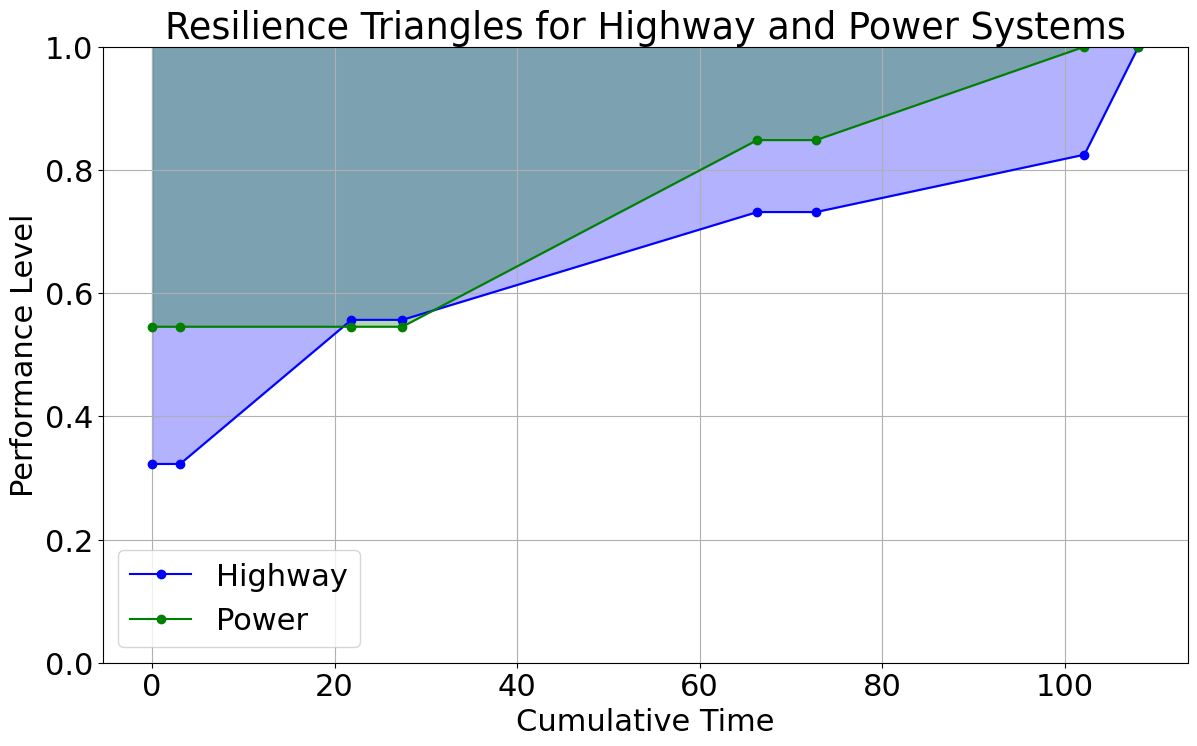

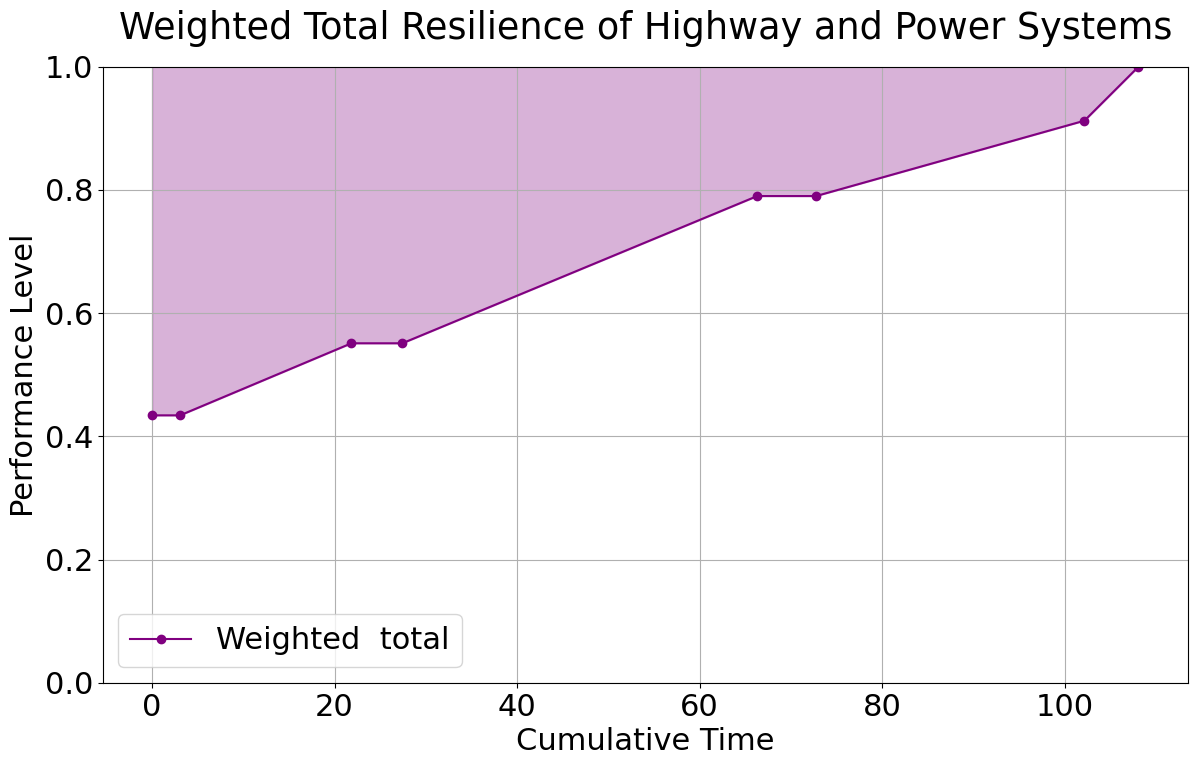

[17, (9, 10), 15, 11, 32, 28, (11, 14)]

In [27]:

run_model(sequence,True,result_folder,"This is SENSITIVITY #4, traffic light location",'SENS4',True)


In [28]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS4",'optPowerSENS4',False)
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS4",'optRoadSENS4',False)

Initial population:
[32, 28, 17, 11, 15]
[15, 17, 11, 32, 28]
[15, 28, 32, 17, 11]
[15, 32, 28, 17, 11]
[11, 15, 28, 17, 32]
gen	nevals	avg    	min                 	max                  
0  	100   	61.1675	(34.17123621882265,)	(101.39061354682711,)
1  	59    	45.255 	(34.17123621882265,)	(94.41353727166454,) 
2  	51    	39.5547	(33.749758573973324,)	(94.41353727166454,) 
3  	60    	35.6663	(33.749758573973324,)	(83.29916510505593,) 
4  	57    	35.8027	(33.749758573973324,)	(69.2318103376656,)  
5  	62    	36.3849	(33.749758573973324,)	(72.30221971594196,) 
6  	60    	35.8241	(33.749758573973324,)	(72.12808954166967,) 
7  	57    	34.7835	(33.749758573973324,)	(63.8262470765265,)  
8  	59    	34.4581	(33.749758573973324,)	(63.8262470765265,)  
9  	58    	35.6255	(33.749758573973324,)	(78.06701709794078,) 
10 	56    	36.0246	(33.749758573973324,)	(92.74468729606994,) 
11 	49    	35.1927	(33.749758573973324,)	(92.74468729606994,) 
12 	72    	35.226 	(33.749758573973324,)	(72.30221971594196

eval


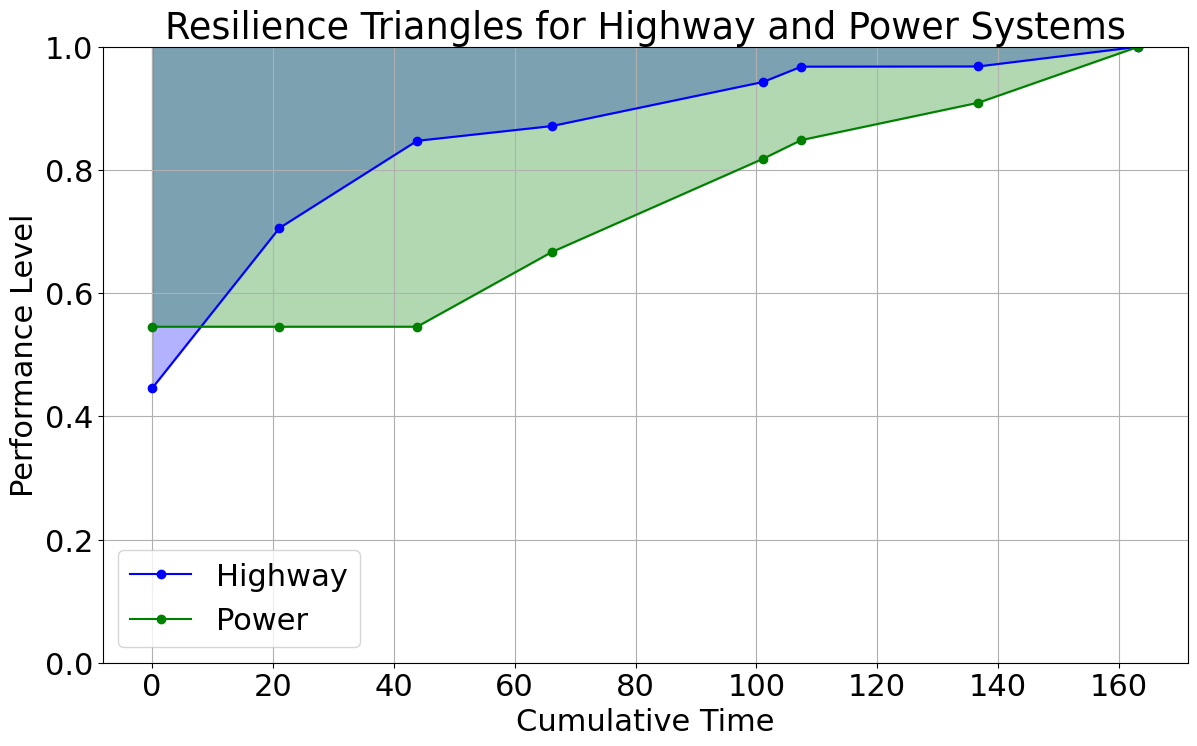

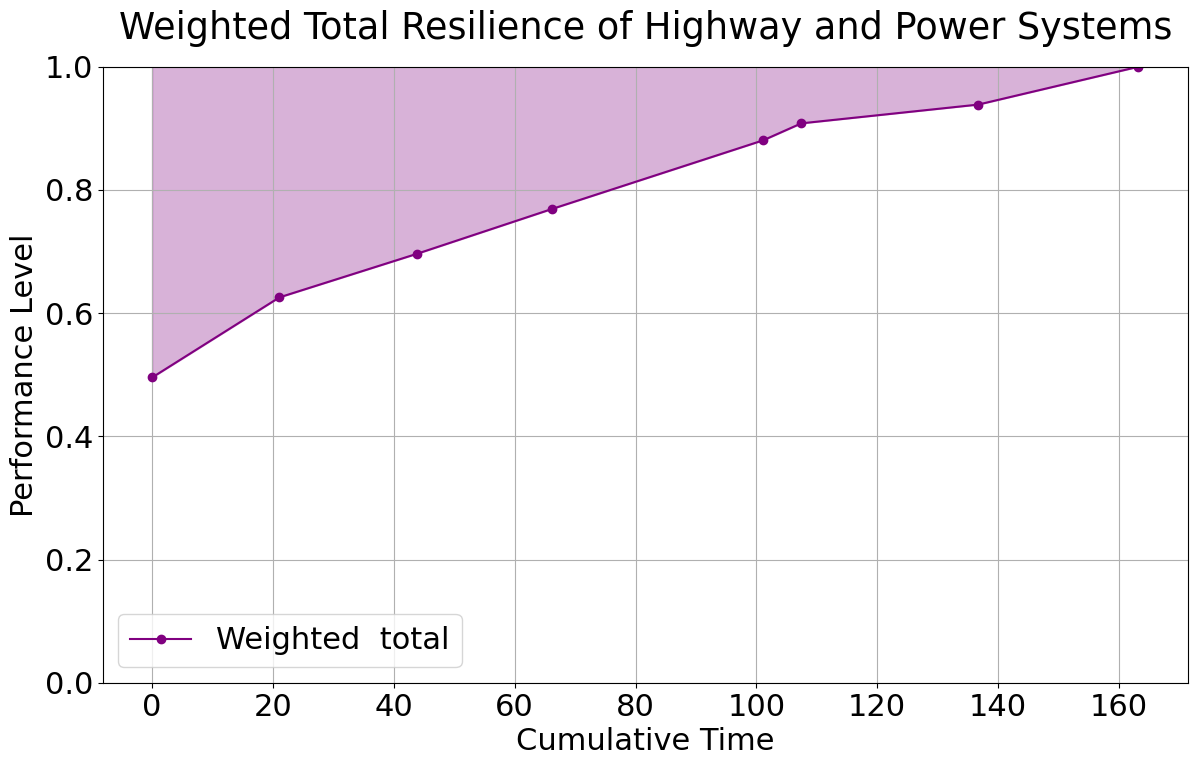

[(9, 10), (11, 14), 28, 11, 32, 15, 17]

In [29]:
run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS4",'evalRoadPrioritySENS4',True)


eval


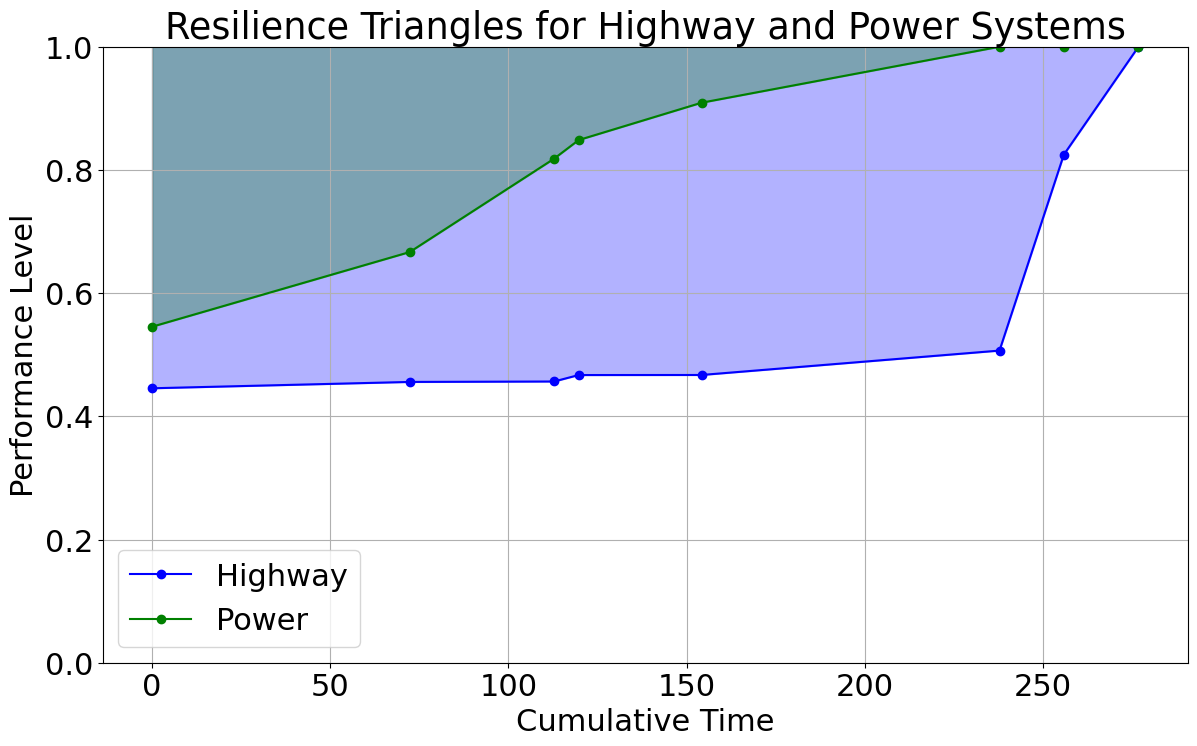

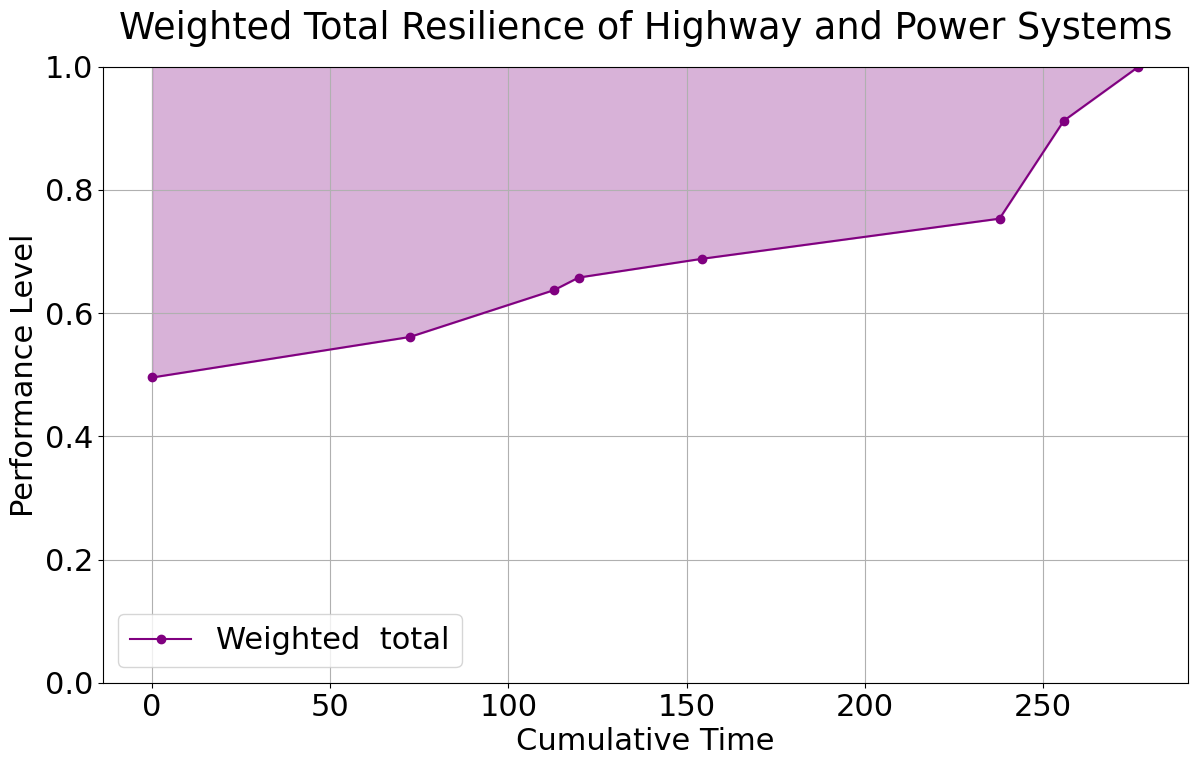

[28, 11, 32, 15, 17, (9, 10), (11, 14)]

In [30]:
run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS4",'evalPowerPrioritySENS4',True)

Sensitivity #5
One directional interdependency

Initial population:
[15, 32, 17, 11, (11, 14), (9, 10), 28]
[(9, 10), 28, 11, 15, 32, 17, (11, 14)]
[15, (11, 14), (9, 10), 11, 28, 32, 17]
[(11, 14), 28, 15, 32, (9, 10), 11, 17]
[28, 32, (11, 14), 17, 15, 11, (9, 10)]
gen	nevals	avg    	min                  	max                 
0  	100   	139.431	(52.743717084622276,)	(277.6692367865086,)
1  	67    	87.3816	(47.44155013019868,) 	(231.34161837433538,)
2  	53    	67.8546	(42.93171229427393,) 	(199.33548686693445,)
3  	63    	65.872 	(42.93171229427393,) 	(207.3247413256331,) 
4  	56    	62.9393	(42.93171229427393,) 	(215.73106898705169,)
5  	62    	59.4511	(42.93171229427393,) 	(263.9304456862495,) 
6  	67    	51.3372	(42.93171229427393,) 	(198.22081394336357,)
7  	59    	50.4204	(42.93171229427393,) 	(198.22081394336357,)
8  	77    	49.514 	(42.93171229427393,) 	(218.77596735740127,)
9  	57    	48.675 	(42.93171229427393,) 	(178.53537963392824,)
10 	57    	50.3382	(42.93171229427393,) 	(212.46106420463494,)
11 	60    	48.7841	(42.931

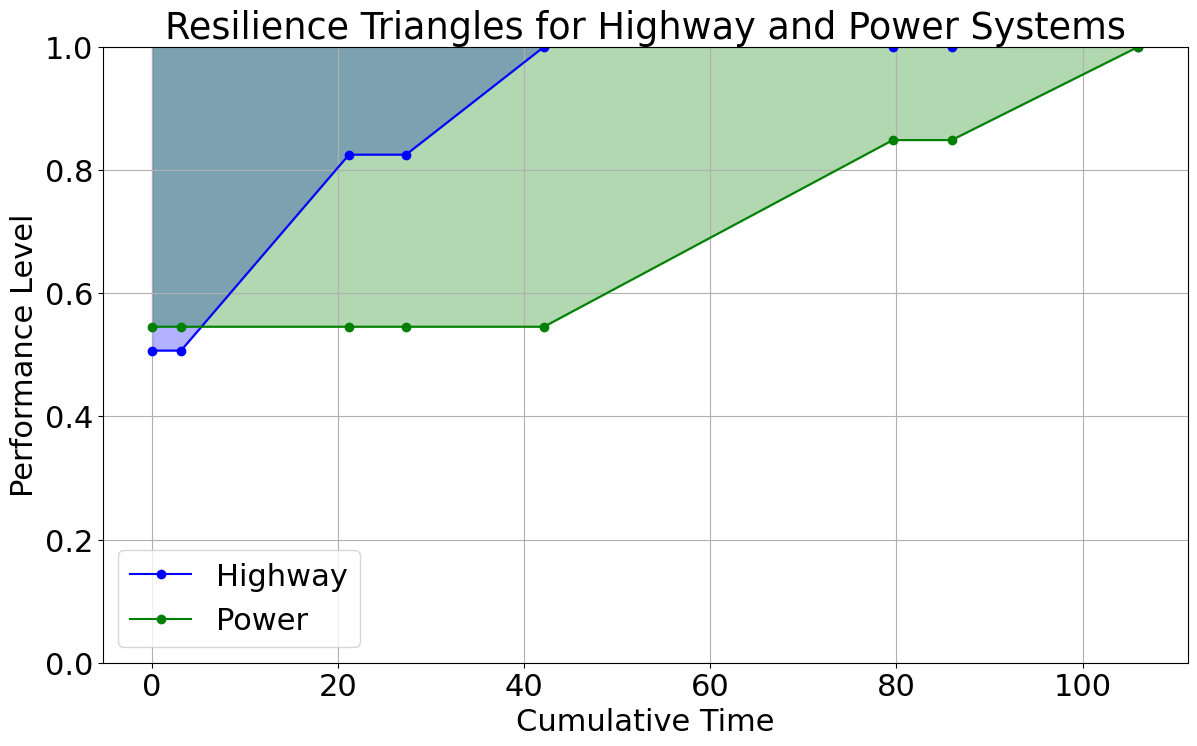

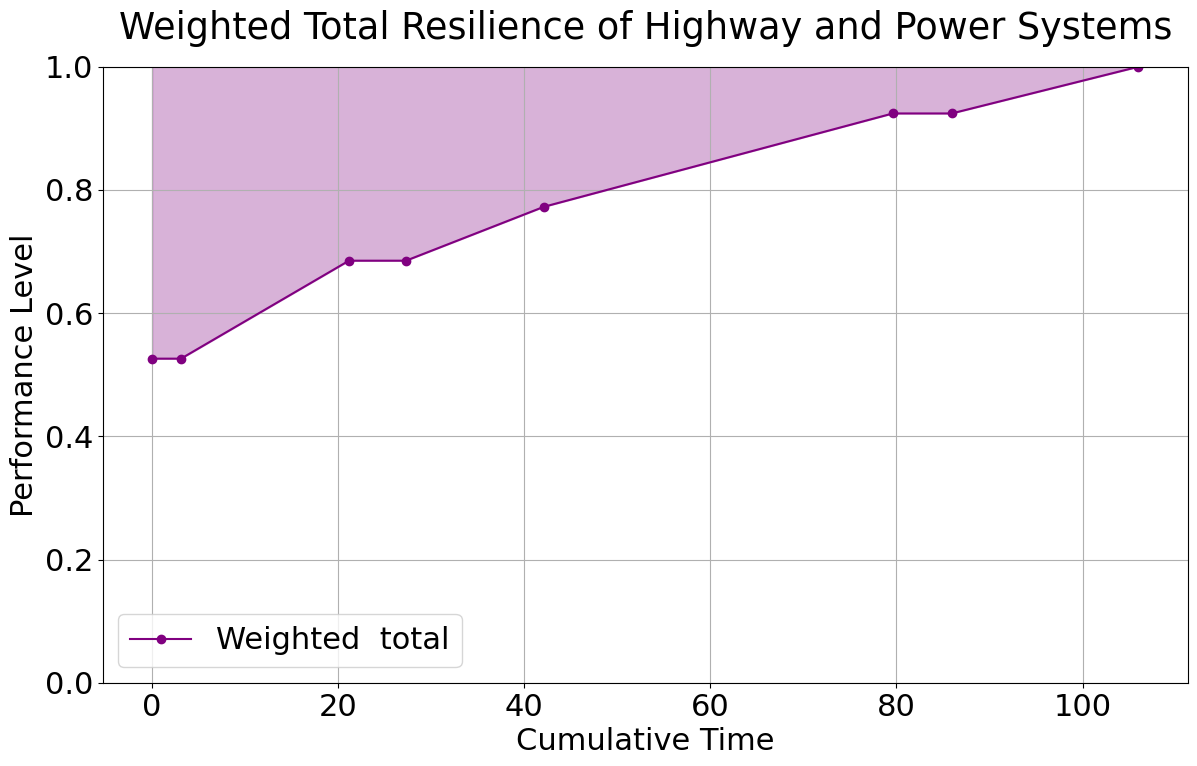

[17, (9, 10), 15, (11, 14), 11, 32, 28]

In [31]:
power_road_factor=1.0
run_model(sequence,True,result_folder,"This is SENSITIVITY #5, one directional interdependency",'SENS5',True)

In [32]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS5",'optPowerSENS5',False)
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS5",'optRoadSENS5',False)


Initial population:
[17, 15, 28, 32, 11]
[32, 17, 15, 28, 11]
[17, 11, 15, 28, 32]
[28, 11, 17, 15, 32]
[17, 32, 28, 15, 11]
gen	nevals	avg    	min                  	max                 
0  	100   	35.6827	(20.706482152965094,)	(64.65009252853199,)
1  	50    	26.7113	(20.48259596944059,) 	(52.68099996470974,)
2  	66    	22.7539	(20.48259596944059,) 	(59.43118931597982,)
3  	56    	22.7253	(20.48259596944059,) 	(43.71961098978949,)
4  	66    	23.1489	(20.48259596944059,) 	(59.43118931597982,)
5  	59    	21.8648	(20.48259596944059,) 	(42.65923855657143,)
6  	47    	20.7461	(20.48259596944059,) 	(34.88015173880972,)
7  	52    	21.4862	(20.48259596944059,) 	(40.33089780714812,)
8  	67    	22.2229	(20.48259596944059,) 	(39.41741813706984,)
9  	54    	21.6395	(20.48259596944059,) 	(49.959098917810394,)
10 	65    	21.5747	(20.48259596944059,) 	(38.81869861967068,) 
11 	51    	21.819 	(20.48259596944059,) 	(43.91219531010161,) 
12 	61    	21.9876	(20.48259596944059,) 	(38.31625129885358,) 
13 

eval


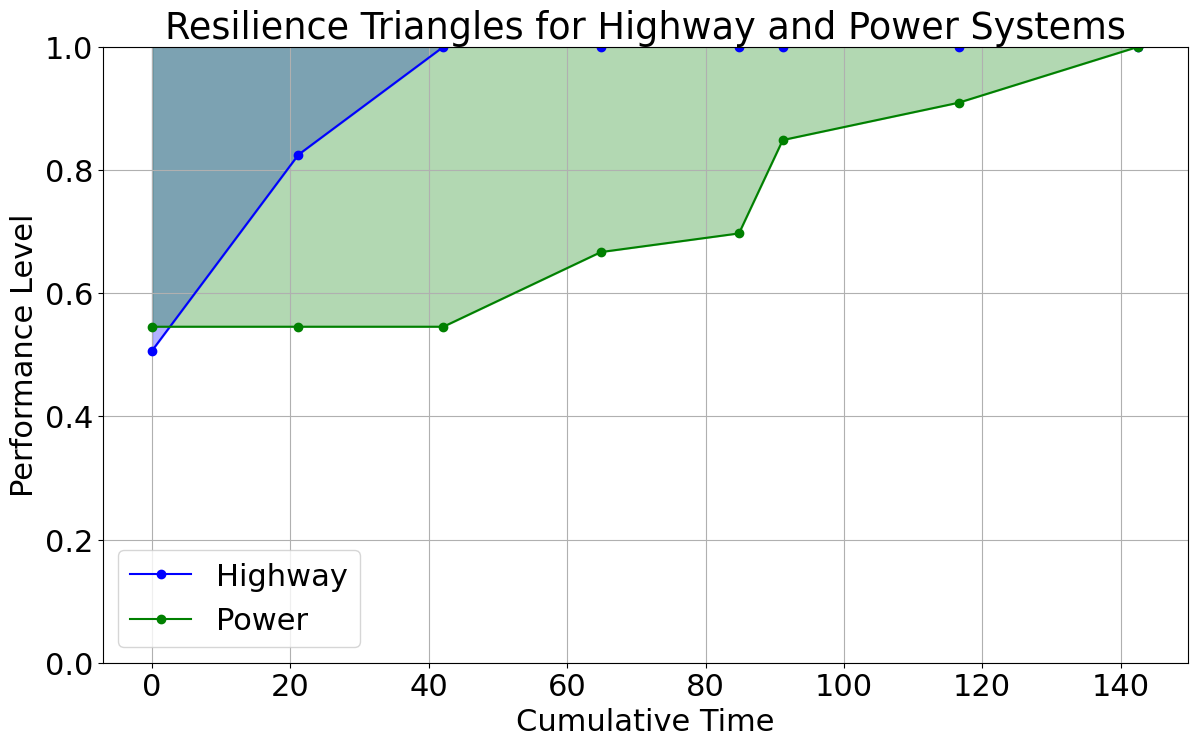

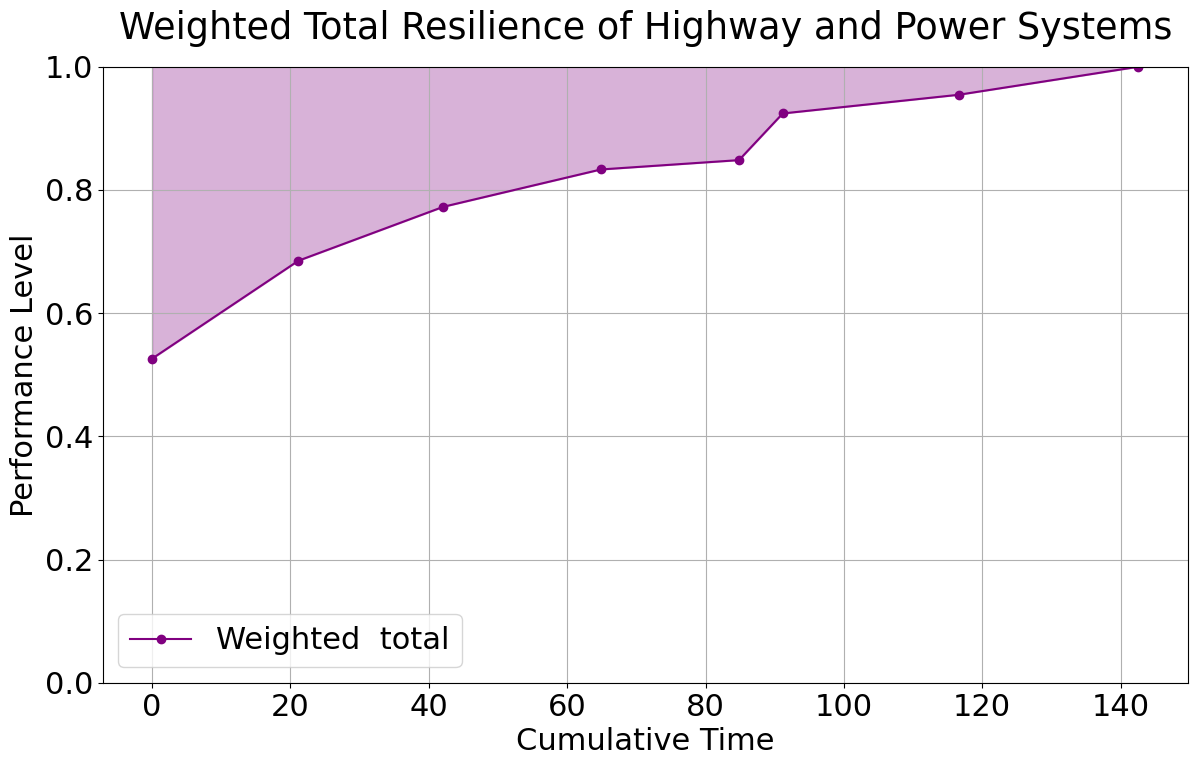

[(9, 10), (11, 14), 28, 32, 11, 15, 17]

In [33]:
run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS5",'evalRoadPrioritySENS5',True)


eval


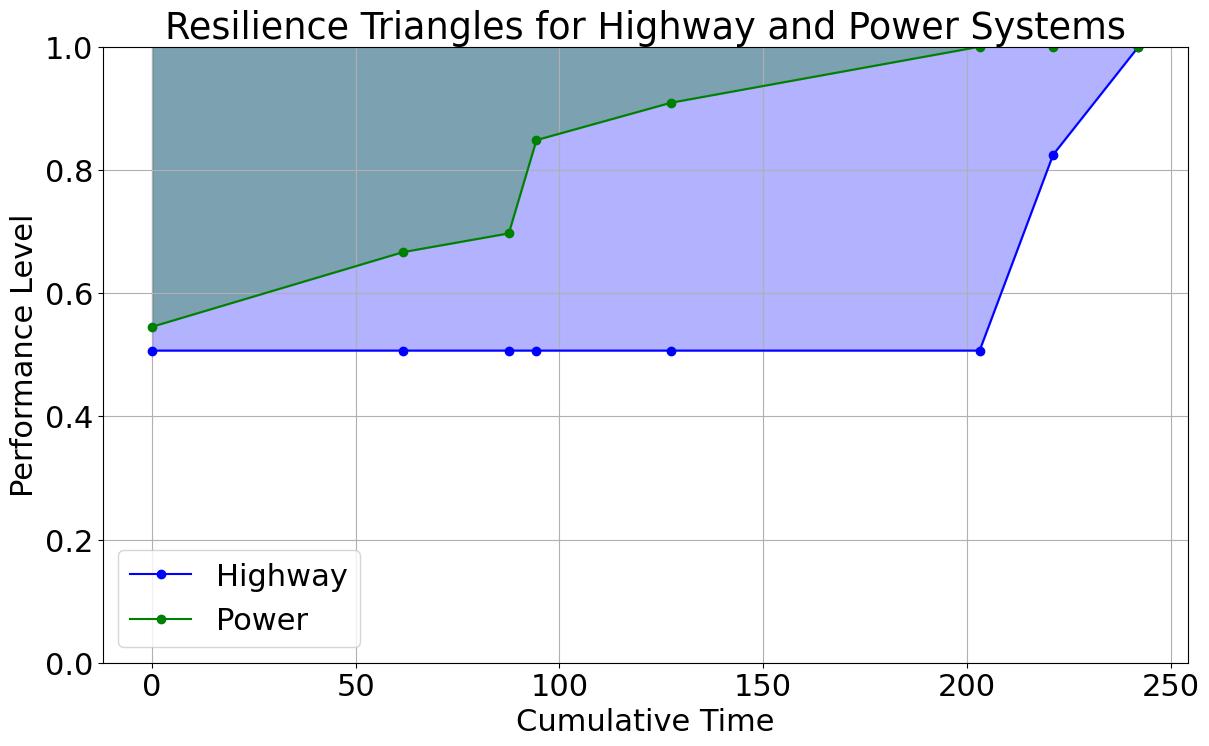

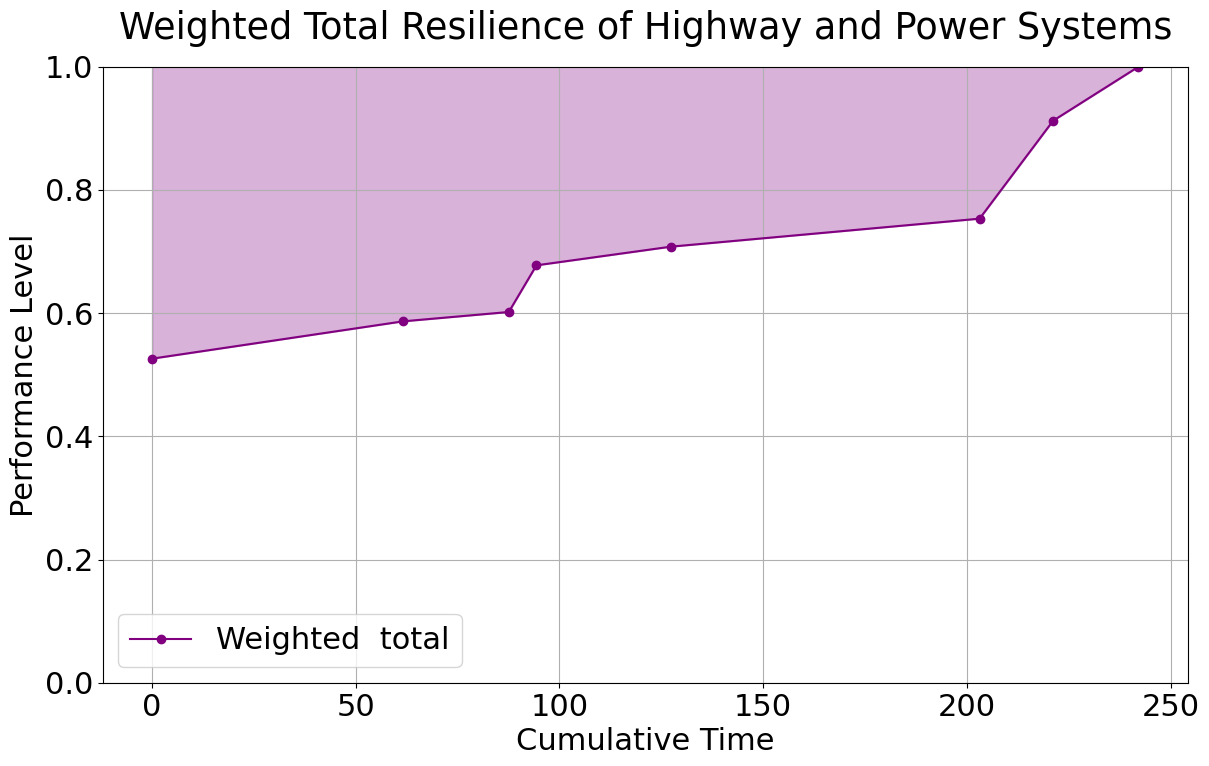

[28, 32, 11, 15, 17, (9, 10), (11, 14)]

In [34]:
run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS5",'evalPowerPrioritySENS5',True)

Now This Generate some comparison sequence:
1. Compare default vs random
2. Compare default vs 2 priorities
3. SENS more broken compare with 2 priorities
4. SENS More severity vs 2 priorities
5. SENS default vs single dir   

Below are the hand made for QA purposes

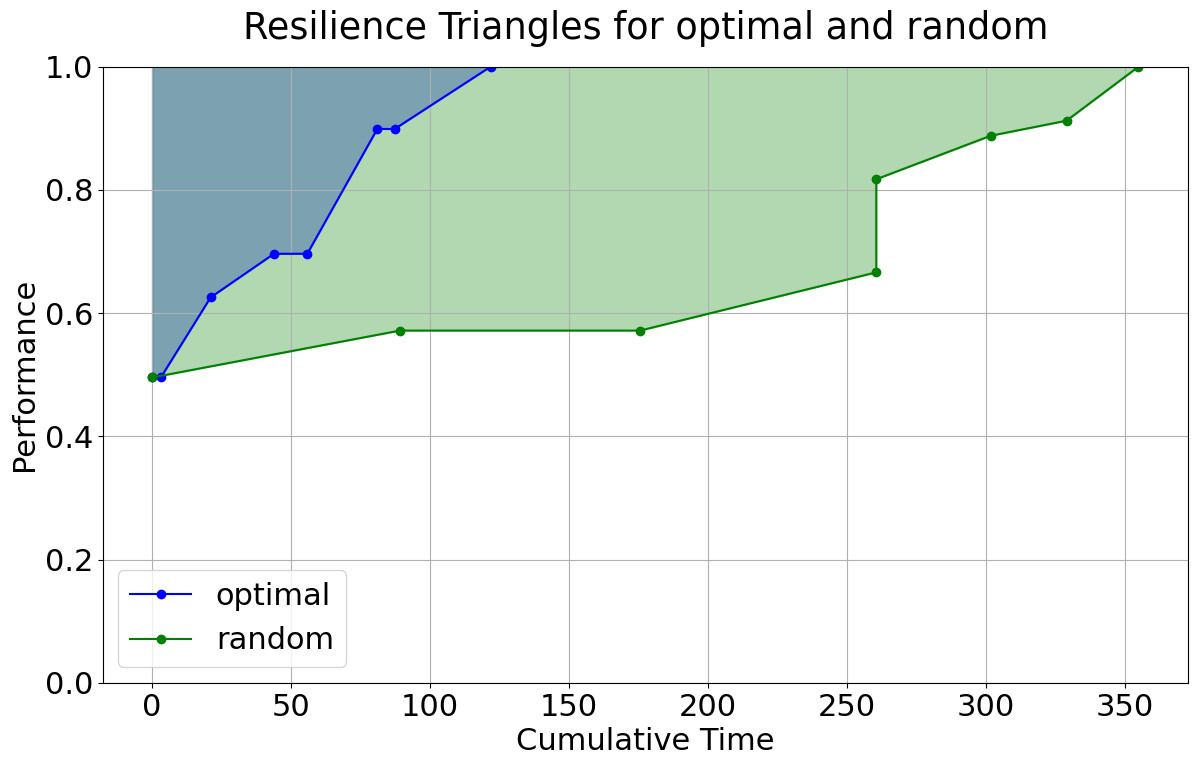

In [35]:
from plot_resilience import plot_triangles_compare2
default_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.133136, 17.931908, 22.778905, 11.996568, 25.178403, 6.258539, 34.487867]
random_seq=[11, 17, 15, (9, 10), 28, 32, (11, 14)]
random_resilience_road=[0.44553396095539116, 0.4464119913694029, 0.4464119913694029, 0.48397038317426355, 0.7862485062991831, 0.8060812859348895, 0.8247797898029301]
random_resilience_power=[0.5454545454545454, 0.696969696969697, 0.696969696969697, 0.8484848484848485, 0.8484848484848485, 0.9696969696969697, 1.0]
random_time=[89.172595, 86.403648, 84.97575900000001, 0, 41.120753, 27.328841000000004, 25.881401]
random_resilience = [(a + b)/2 for a, b in zip(random_resilience_power, random_resilience_road)]
plot_triangles_compare2(default_resilience, random_resilience,default_time,random_time,'optimal','random','compare_random_default')

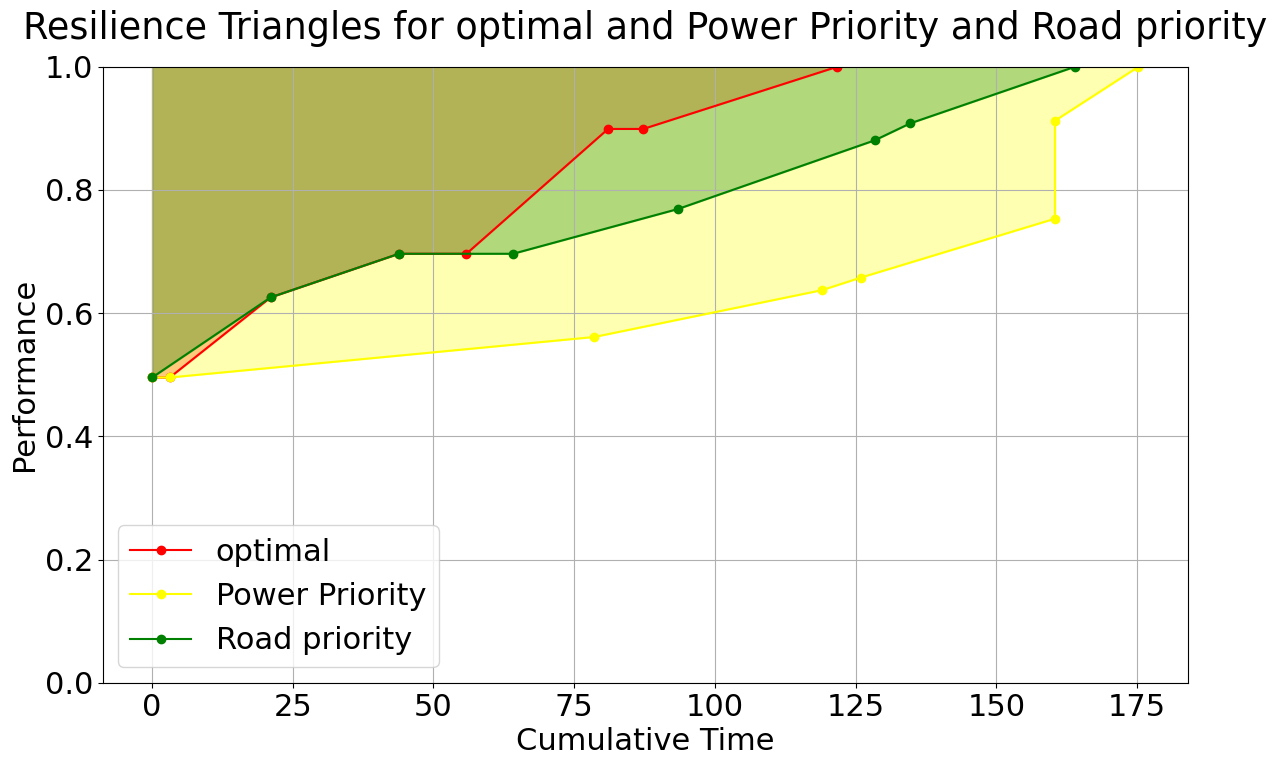

In [36]:
from plot_resilience import plot_triangles_compare3
default_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.133136, 17.931908, 22.778905, 11.996568, 25.178403, 6.258539, 34.487867]

Power_priority_seq=[17, 28, 11, 32, 15, (9, 10), (11, 14)]
Power_priority_road=[0.44553396095539116, 0.44553396095539116, 0.4558264932041891, 0.45653825632824463, 0.4670071116299994, 0.5067259434091717, 0.8247797898029301]
Power_priority_power=[0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 1.0, 1.0]
Power_priority_time=[3.133136, 75.417666, 40.50453199999999, 6.902298, 34.483877, 0, 14.82433]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (11, 14), 17, 28, 11, 32, 15]
Road_priority_road=[0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.8712142852391935, 0.9428075561942305, 0.9676814075940526]
Road_priority_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485]
Road_priority_time=[21.065044, 22.778905, 20.296706, 29.270722, 34.977188, 6.320784, 29.284549]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'optimal','Power Priority','Road priority','compare_deault_priority_default')

More links

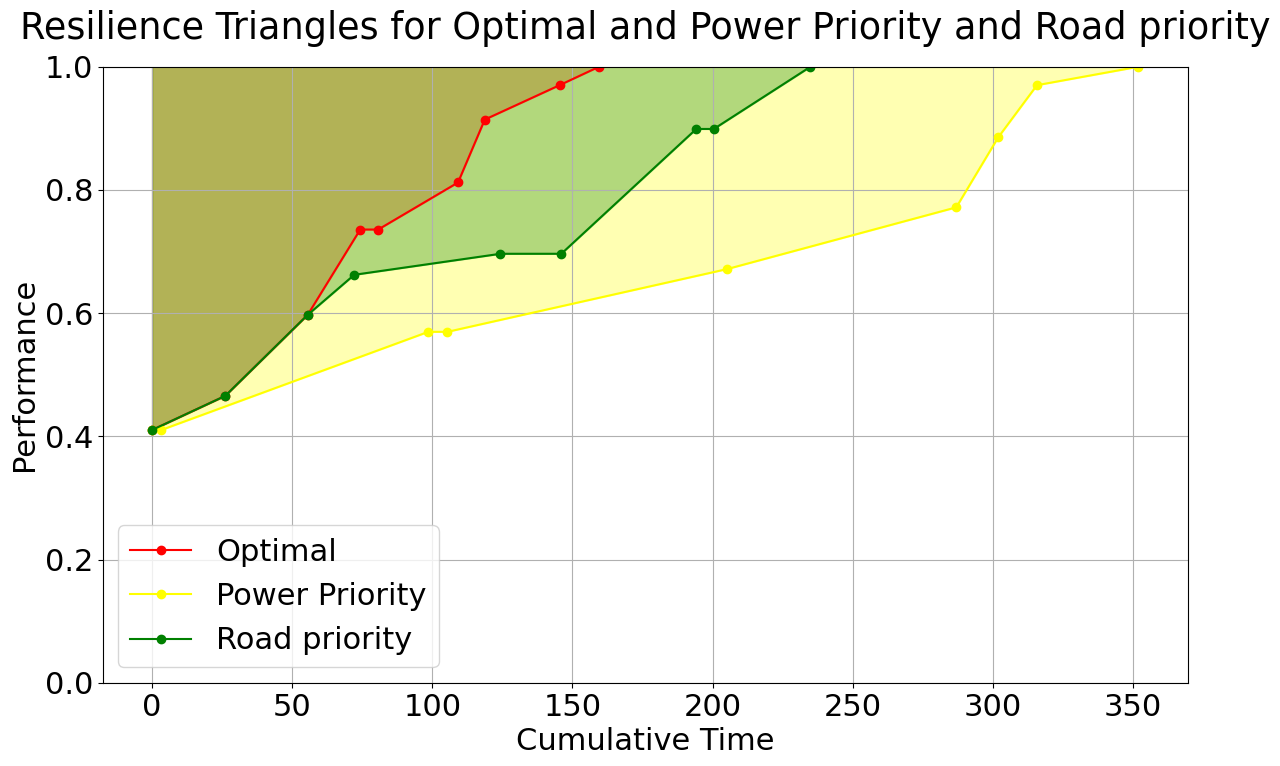

In [37]:
from plot_resilience import plot_triangles_compare3
default_seq=[(9, 10), (15, 22), 11, 32, (11, 14), 28, 17, (2, 6)]
default_resilience_road=[0.2751974005330034, 0.38591520708763666, 0.64893021416943, 0.7138279187378157, 0.7138279187378157, 0.8665601600799147, 0.9193135206296982, 0.9400822150101154]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.7575757575757576, 0.7575757575757576, 0.7575757575757576, 0.9090909090909091, 1.0]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[26.110763000000002, 29.405070000000002, 18.748646, 6.4153199999999995, 28.484389999999998, 9.545323, 26.694956, 14.068439000000001]

Power_priority_seq=[17, 11, 32, 28, (9, 10), (15, 22), (11, 14), (2, 6)]
Power_priority_road= [0.2751974005330034, 0.2751974005330034, 0.29084029029968783, 0.29084029029968783, 0.34299790015410614, 0.5435080699192547, 0.7709356539229091, 0.9400822150101154]
Power_priority_power=[0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485, 1.0, 1.0, 1.0, 1.0]
Power_priority_time= [3.300229, 95.26665500000001, 6.8408169999999995, 99.756878, 81.795873, 14.979011, 13.810443, 36.221855000000005]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (15, 22), (11, 14), (2, 6), 17, 11, 32, 28]
Road_priority_road=[0.2751974005330034, 0.38591520708763666, 0.64893021416943, 0.7789824728993422, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
Road_priority_power= [0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
Road_priority_time=[26.110763000000002, 29.405070000000002, 16.613488, 52.192296999999996, 21.702342, 48.162824, 6.258539, 34.487867]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

change in point

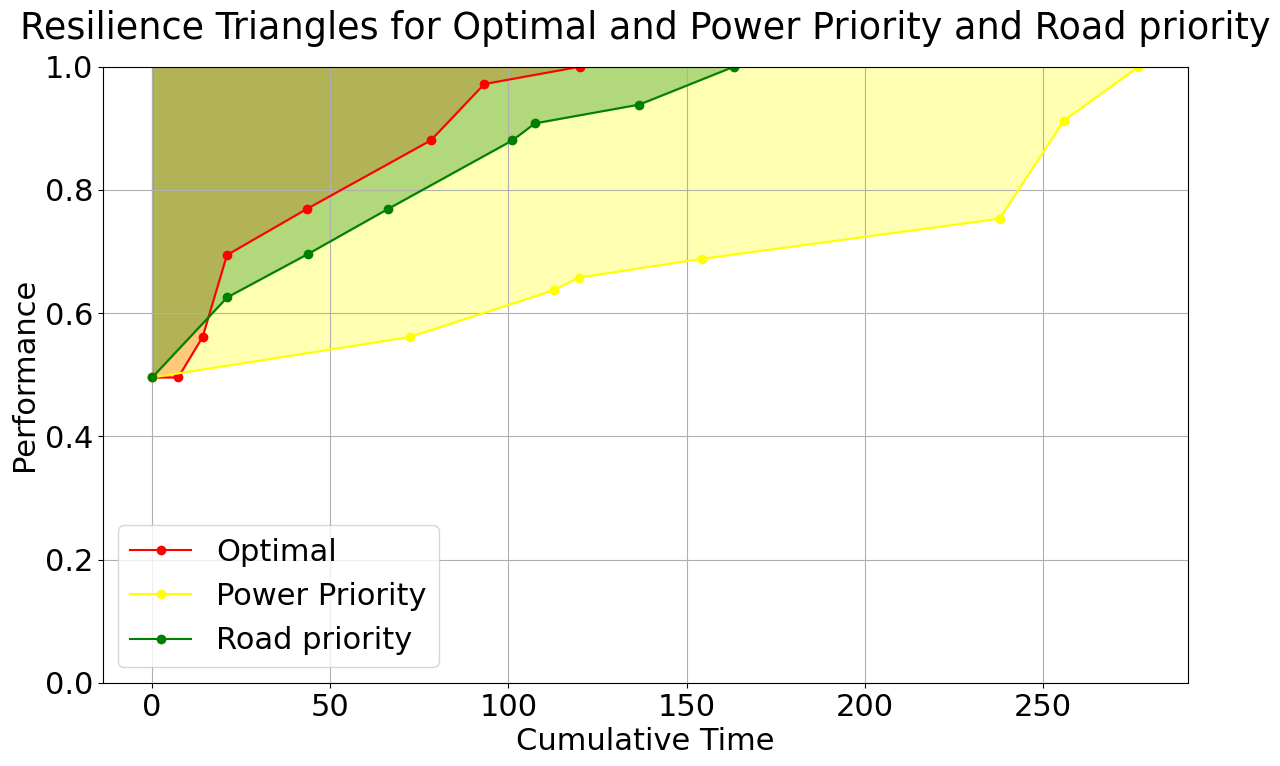

In [43]:
from plot_resilience import plot_triangles_compare3
default_seq=[17, 28, (9, 10), (11, 14), 11, 15, 32]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.4558264932041891, 0.7220365350641481, 0.8712142852391935, 0.9428075561942305, 0.9741351658932144]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.6666666666666667, 0.6666666666666667, 0.8181818181818181, 0.9696969696969697]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[7.307385999999999, 6.865093, 6.840451, 22.342840000000002, 34.860305, 15.016524, 26.778851]

Power_priority_seq=[28, 11, 32, 15, 17, (9, 10), (11, 14)]
Power_priority_road= [0.44553396095539116, 0.4558264932041891, 0.45653825632824463, 0.4670071116299994, 0.4671176638328456, 0.5067259434091717, 0.8247797898029301]
Power_priority_power=[0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 0.9090909090909091, 1.0, 1.0]
Power_priority_time= [72.288397, 40.50453199999999, 6.902298, 34.483877, 83.627304, 18.050473, 20.944219]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (11, 14), 28, 11, 32, 15, 17]
Road_priority_road=[0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.8712142852391935, 0.9428075561942305, 0.9676814075940526, 0.9680063048354032]
Road_priority_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 0.9090909090909091]
Road_priority_time=[21.065044, 22.778905, 22.291117, 34.977188, 6.320784, 29.284549, 26.510815]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

move the connection around

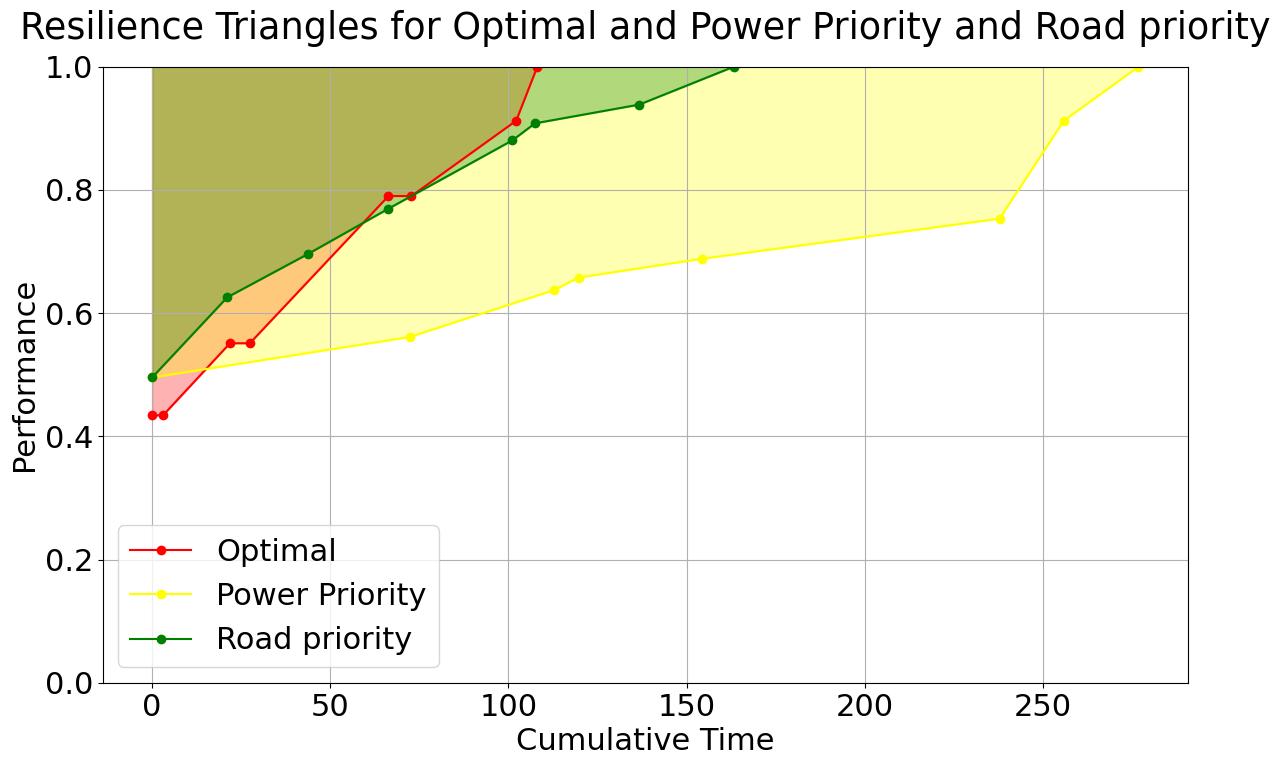

In [44]:
from plot_resilience import plot_triangles_compare3
default_seq=[17, (9, 10), 15, 11, 32, 28, (11, 14)]
default_resilience_road=[0.3226873635320036, 0.3226873635320036, 0.5566374056201964, 0.5566374056201964, 0.7316296448229149, 0.7316296448229149, 0.8247797898029301]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485, 1.0]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.066577, 18.773938, 5.582944, 38.893453, 6.449008, 29.409074, 5.92389]

Power_priority_seq=[28, 11, 32, 15, 17, (9, 10), (11, 14)]
Power_priority_road= [0.44553396095539116, 0.4558264932041891, 0.45653825632824463, 0.4670071116299994, 0.4671176638328456, 0.5067259434091717, 0.8247797898029301]
Power_priority_power= [0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 0.9090909090909091, 1.0, 1.0]
Power_priority_time= [72.288397, 40.50453199999999, 6.902298, 34.483877, 83.627304, 18.050473, 20.944219]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (11, 14), 28, 11, 32, 15, 17]
Road_priority_road=[0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.8712142852391935, 0.9428075561942305, 0.9676814075940526, 0.9680063048354032]
Road_priority_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 0.9090909090909091]
Road_priority_time=[21.065044, 22.778905, 22.291117, 34.977188, 6.320784, 29.284549, 26.510815]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

More severity

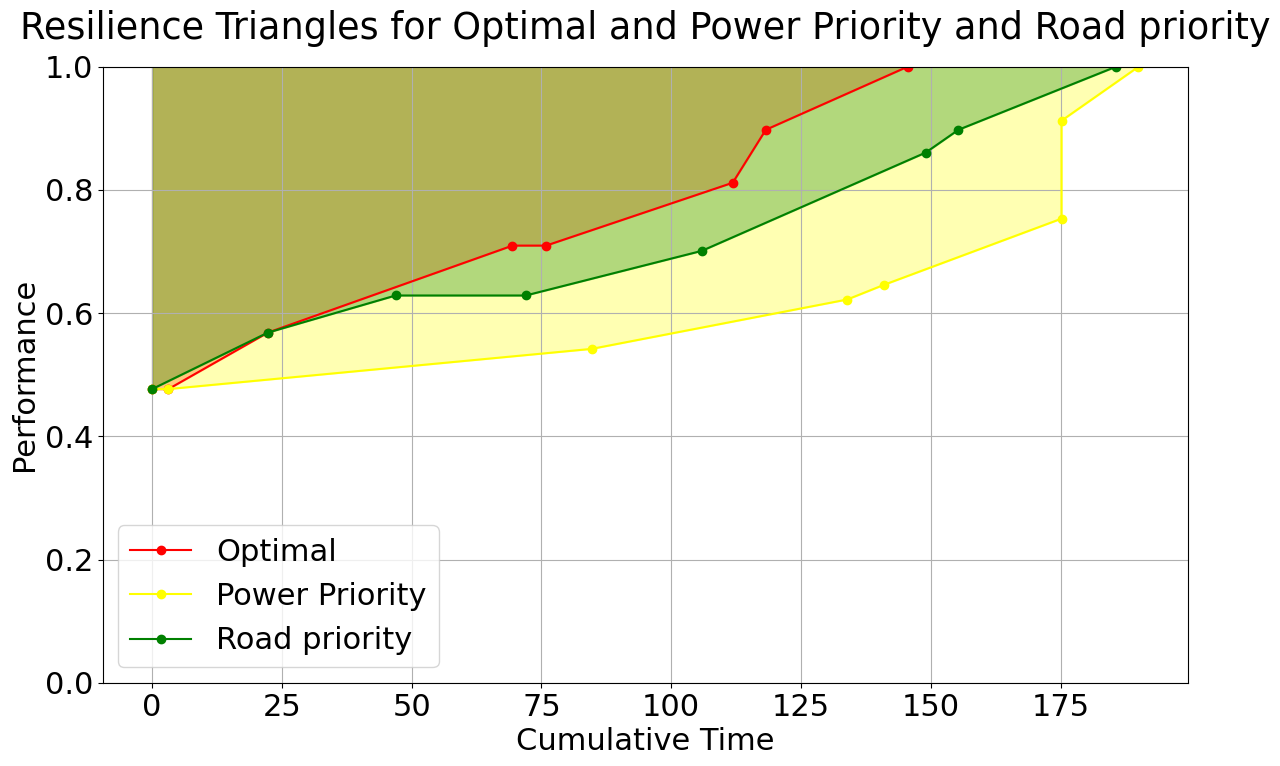

In [40]:
from plot_resilience import plot_triangles_compare3
default_seq=[17, (9, 10), 11, 32, 28, (11, 14), 15]
default_resilience_road=[0.40797797789421464, 0.40797797789421464, 0.5913013424621747, 0.7222697986191966, 0.7222697986191966, 0.77482884824175, 0.9468443263798874]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.696969696969697, 0.696969696969697, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.13807, 19.160594000000003, 47.127936000000005, 6.470439, 35.949723000000006, 6.378484, 27.305132999999998]

Power_priority_seq=[17, 28, 11, 32, 15, (9, 10), (11, 14)]
Power_priority_road=  [0.40797797789421464, 0.40797797789421464, 0.4173107978488609, 0.4260298686234501, 0.44293931137687736, 0.5067259434091717, 0.8247797898029301]
Power_priority_power=[0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485, 1.0, 1.0]
Power_priority_time= [3.13807, 81.56169899999999, 49.20872599999999, 7.012449, 34.270405999999994, 0, 14.82433]
Power_priority_resilience = [(a + b)/2 for a, b in zip(Power_priority_power, Power_priority_road)]

Road_priority_seq=[(9, 10), (11, 14), 17, 28, 11, 32, 15]
Road_priority_road=[0.40797797789421464, 0.5913013424621747, 0.7117890450408939, 0.7117890450408939, 0.735507930227685, 0.903100606856624, 0.9468443263798874]
Road_priority_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8181818181818181, 0.8484848484848485]
Road_priority_time=[22.298664000000002, 24.599747999999998, 25.070833, 33.926485, 43.13199, 6.311872, 30.3358]
Road_priority_resilience = [(a + b)/2 for a, b in zip(Road_priority_power, Road_priority_road)]

plot_triangles_compare3(default_resilience, Power_priority_resilience,Road_priority_resilience,default_time,Power_priority_time,Road_priority_time,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

Put back sensitivity 5

In [41]:
power_road_factor=0.5
SENS5_result=[(9, 10), 15, (11, 14), 28, 11, 32, 17]
run_model(SENS5_result,True,result_folder,"This is for sens5 on regular factor",'evalSENS5',False)

eval



[(9, 10), 15, (11, 14), 28, 11, 32, 17]

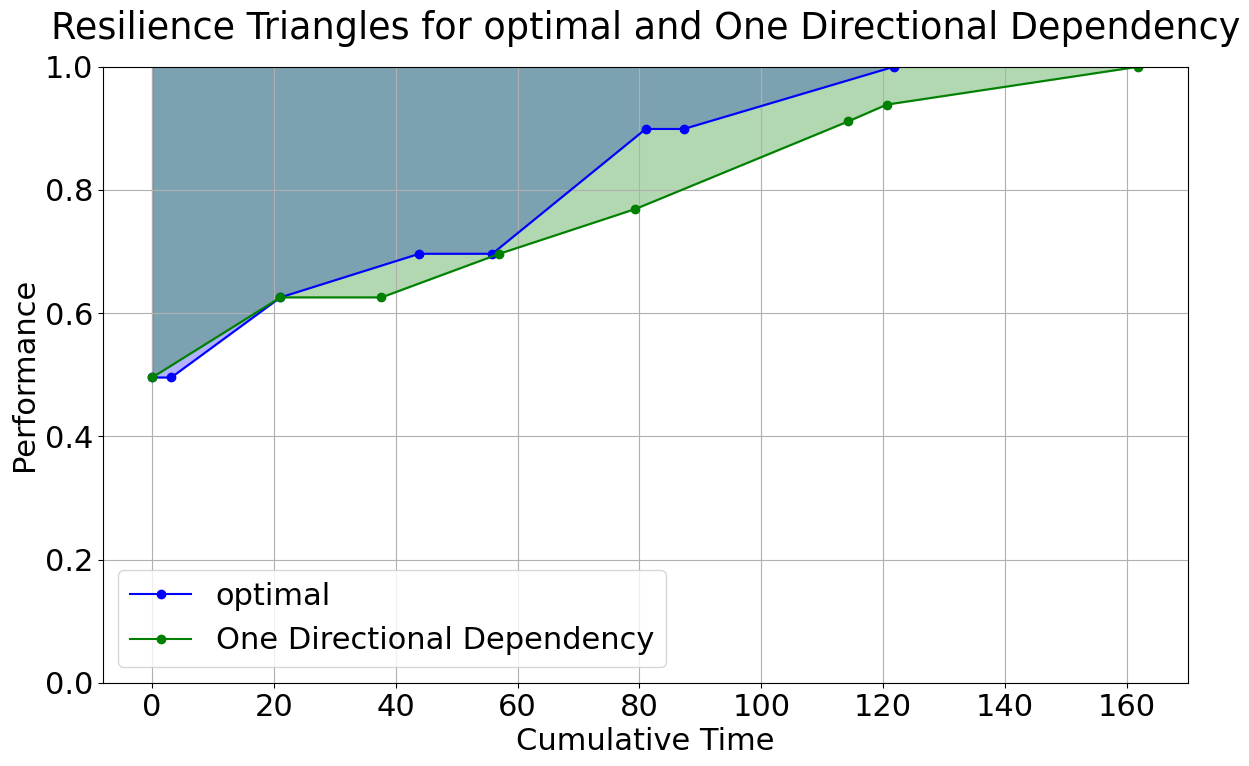

In [42]:
from plot_resilience import plot_triangles_compare2
default_seq=[17, (9, 10), (11, 14), 15, 11, 32, 28]
default_resilience_road=[0.44553396095539116, 0.44553396095539116, 0.7056831520794121, 0.847252092630669, 0.847252092630669, 0.949464697637762, 0.949464697637762]
default_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.8484848484848485, 0.8484848484848485]
default_resilience = [(a + b)/2 for a, b in zip(default_resilience_power, default_resilience_road)]
default_time=[3.133136, 17.931908, 22.778905, 11.996568, 25.178403, 6.258539, 34.487867]
SENS5_seq=[(9, 10), 15, (11, 14), 28, 11, 32, 17]
SENS5_resilience_road=[0.44553396095539116, 0.7056831520794121, 0.7056831520794121, 0.847252092630669, 0.8712142852391935, 0.943880991842476, 0.9680063048354032]
SENS5_resilience_power=[0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.6666666666666667, 0.8787878787878788, 0.9090909090909091]
SENS5_time=[21.065044, 16.588904, 19.351115, 22.291117, 34.977188, 6.319184, 41.318273000000005]
SENS5_resilience = [(a + b)/2 for a, b in zip(SENS5_resilience_power, SENS5_resilience_road)]
plot_triangles_compare2(default_resilience, SENS5_resilience,default_time,SENS5_time,'optimal','One Directional Dependency','compare_one-dir_default')

Sensitivity #X not used
Demand pattern, like 50% demand in at time 0 and gradual recover? hard to design
